In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedFormatter, FixedLocator
import os
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import colourblind as cb
from seaborn import color_palette as cp

In [39]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

In [40]:
# Load in trade data
trade_path = './data/trade_data.csv'
trade_df = pd.read_csv(trade_path)

# Load in iso country codes
iso_path = './data/trade_country_iso.csv'
iso_df = pd.read_csv(iso_path)

In [41]:
# Trade values in $1000 USD
trade_df.info()
trade_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829092 entries, 0 to 829091
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   reporter  829092 non-null  object 
 1   partner   829092 non-null  object 
 2   year      829092 non-null  int64  
 3   export    703655 non-null  float64
 4   import    770925 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 31.6+ MB


reporter partner  year    export    import
0      AFG     AUS  2008    10.692   129.485
1      AFG     AUS  2009     8.462  1214.034
2      AFG     AUS  2010   648.457  1329.447
3      AFG     AUS  2011   111.502  1301.370
4      AFG     AUS  2015  1296.260  1259.046

In [42]:
""" Editing a file to get the iso codes associated with each region.
Data is taken from https://wits.worldbank.org/countryprofile/metadata/en/country/all
I could not find this data in the API hence this solution."""

def get_region(line):
    items = line.split('    ')[0].split('\t')
    try:
        if len(items[1]) == 3 and items[6]:
            return {'region':items[6],'iso3':items[1]}
        else:
            return None
    except IndexError:
        return None

overwrite = False # Manually change if file overwrite needed
region_path = './data/region_iso.csv'

# Check if API request already done
if not(os.path.exists(region_path)) or overwrite:

    to_edit_path = './data/region_to_edit.csv'  # Taken from WITS website
    region_file = open(to_edit_path, 'r')
    lines = region_file.readlines()
    region_file.close()

    region_pairs = []
    for line in lines:
        region_pair = get_region(line)
        if region_pair is not None:
            region_pairs.append(region_pair)

    region_isos_df = pd.DataFrame(region_pairs).sort_values('region')
    region_isos_df.to_csv(region_path, index=False)

region_isos_df = pd.read_csv(region_path)

In [43]:
# Region data info
region_isos_df.info()
region_isos_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  203 non-null    object
 1   iso3    203 non-null    object
dtypes: object(2)
memory usage: 3.3+ KB


region iso3
0  East Asia & Pacific  KOR
1  East Asia & Pacific  BRN
2  East Asia & Pacific  TMP
3  East Asia & Pacific  MMR
4  East Asia & Pacific  KHM

In [44]:
"""Creating DataFrames that separates the regions from the countries, then validating
the results by comparing the sums to the values taken based off of the websites categories.

WLD value is always correct there are occasional discrepancies with the regions and
countries."""
countries_path = './data/countries.csv'
regions_path = './data/regions.csv'
overwrite = False  # Manually change if file overwrite needed

if not(os.path.exists(countries_path)) or not(os.path.exists(regions_path)) or overwrite:
    # World and Region filtered Series
    region_series_partner = [
         trade_df[trade_df['partner'] == 'WLD'],trade_df[trade_df['partner'] == 'LCN'],trade_df[trade_df['partner'] == 'MEA'],trade_df[trade_df['partner'] == 'NAC'],trade_df[trade_df['partner'] == 'ECS'],trade_df[trade_df['partner'] == 'SAS'],trade_df[trade_df['partner'] == 'SSF'],trade_df[trade_df['partner'] == 'EAS']
        ]

    region_codes = ['WLD','LCN','MEA','NAC','ECS','SAS','SSF','EAS','Wld']

    # Combined Regions DataFrame
    region_df = pd.concat(region_series_partner)

    # Removing the regions partners
    countries_df = trade_df
    for region in region_series_partner:
        countries_df = countries_df.drop(region.index)

    # Removing the regions reporters
    for region in region_codes:
        countries_df = countries_df[countries_df['reporter'] != region]

    # Export countries_df and region_df to csv
    countries_df.to_csv(countries_path, index=False)
    region_df.to_csv(regions_path, index=False)

else:
    countries_df = pd.read_csv(countries_path)
    region_df = pd.read_csv(regions_path)

countries_df.head()

reporter partner  year    export    import
0      AFG     AUS  2008    10.692   129.485
1      AFG     AUS  2009     8.462  1214.034
2      AFG     AUS  2010   648.457  1329.447
3      AFG     AUS  2011   111.502  1301.370
4      AFG     AUS  2015  1296.260  1259.046

In [45]:
countries_df.isnull().sum()
countries_df.info()
countries_df.groupby(['reporter','partner']).size().sum()
countries_df[countries_df['year']==2021].groupby('reporter').size().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729901 entries, 0 to 729900
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   reporter  729901 non-null  object 
 1   partner   729901 non-null  object 
 2   year      729901 non-null  int64  
 3   export    606857 non-null  float64
 4   import    672831 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 27.8+ MB


26293

In [46]:
""" Verifying the values of regions by comparing the sum to the values """

# Specific year and reporting country to test
year = 2019
country = 'USA'

# Filtered year / reporter region DataFrame
reg_yr_df = region_df[region_df['year'] == year]
reg_yr_ctry_df = reg_yr_df[reg_yr_df['reporter'] == country]

# Filtered year / reporter country DataFrame
year_df = countries_df[countries_df['year'] == year]
country_year_df = year_df[year_df['reporter'] == country]

# The export value of the reporter to the rest of the world
world = reg_yr_ctry_df['export'].values[0]

# Sum of the exports for each partner country
total = country_year_df['export'].sum()

regions = ['East Asia & Pacific','Europe & Central Asia','Latin America & Caribbean','Middle East & North Africa','North America','South Asia','Sub-Saharan Africa','World']

# Each value in 'region_sums' represents the export sum in order of 'regions'
region_sums = [0,0,0,0,0,0,0,total]
for i in range(len(regions)):
    for iso in (region_isos_df[region_isos_df['region'] == regions[i]])['iso3']:
        try:
            region_sums[i] += (country_year_df[country_year_df['partner'] == iso])['export'].values[0]
        except IndexError:
            pass

region_group = reg_yr_ctry_df.groupby('partner')['export']
i=0
for key, group in region_group:
    try:
        value = group.values[0]
    except IndexError:
        value = None
    print(f"{key}: {value:<16} Sum: {region_sums[i]}")
    i+=1

EAS: 387262323.751    Sum: 387262323.751
ECS: 380756190.478    Sum: 380567732.835
LCN: 416351485.876    Sum: 416747516.2009999
MEA: 76957846.077     Sum: 76957846.077
NAC: 292916049.355    Sum: 292916049.355
SAS: 40664491.355     Sum: 40664491.355
SSF: 15501183.111     Sum: 15501183.111000003
WLD: 1644276220.783   Sum: 1644276220.783


In [47]:
# Info on countries DataFrame
print("There are", countries_df['reporter'].nunique(), "unique reporting states and", countries_df['partner'].nunique(), "unique partner states in the dataset.\nA total of",pd.concat([countries_df['reporter'],countries_df['partner']]).nunique(), "unique states in the dataset\n")

print(f"The dataset is between the years {countries_df['year'].min()} and {countries_df['year'].max()}.\n")

print("Null values summary:")
countries_df.isnull().sum()

In [48]:
reporter_size = countries_df.groupby('reporter').size()
print("The number of trade dyads per reporter is as follows:\nminimum: {} ({})\nmaximum {} ({})\nmean: {}\nmedian: {}\nmode: {}\n".format(reporter_size.min(),reporter_size.sort_values().index[0], reporter_size.max(),reporter_size.sort_values().index[-1],round(reporter_size.mean()),reporter_size.median(),reporter_size.mode().values[0]))

# For the specific year of 2018
size_2018 = countries_df[countries_df['year'] == 2018].groupby('reporter').size()
print("The number of trade dyads per reporter in the year 2018 is as follows:\nminimum: {} ({})\nmaximum {} ({})\nmean: {}\nmedian: {}\nmode: {}\n".format(size_2018.min(),size_2018.sort_values().index[0], size_2018.max(),size_2018.sort_values().index[-1],round(size_2018.mean()),size_2018.median(),size_2018.mode().values[0]))

There are 204 unique reporting states and 257 unique partner states in the dataset.
A total of 257 unique states in the dataset

The dataset is between the years 1988 and 2021.

Null values summary:


reporter         0
partner          0
year             0
export      123044
import       57070
dtype: int64

In [49]:
# Find total imports and exports for each country per year

# Group by year and reporter, summing exports and imports
total_trade_df = countries_df.groupby(['year', 'reporter']).agg(total_exports=pd.NamedAgg(column='export', aggfunc='sum'),total_imports=pd.NamedAgg(column='import', aggfunc='sum')).reset_index()

# Replace 0 values with NaN so log can be applied
total_trade_df['total_exports'].replace(0, np.nan, inplace=True)
total_trade_df['total_imports'].replace(0, np.nan, inplace=True)

# Global Import / Export by year
globalIE = total_trade_df.groupby('year').agg(total_exports=pd.NamedAgg(column='total_exports', aggfunc='sum'),total_imports=pd.NamedAgg(column='total_imports', aggfunc='sum')).reset_index()

# Adjusting to be in Trillion USD
globalIE['total_exports'] = globalIE['total_exports']/1e9
globalIE['total_imports'] = globalIE['total_imports']/1e9

The number of trade dyads per reporter is as follows:
minimum: 12 (CYM)
maximum 7500 (DEU)
mean: 3578
median: 3607.0
mode: 109

The number of trade dyads per reporter in the year 2018 is as follows:
minimum: 17 (ABW)
maximum 235 (BEL)
mean: 168
median: 176.5
mode: 234



In [50]:
# Plotting global total import / exports per year

# To log data add this to end of total_trade_df['total_exports']
# .map(lambda x: math.log(x))

plt.figure(figsize=(10,6))
#globalIE.plot(kind = 'bar', stacked = True, x='year', y=['total_exports','total_imports'], ax=plt.gca())
plt.bar(total_trade_df['year'].unique() - 0.2, (total_trade_df.groupby('year')['total_imports'].sum() /1e9), 0.4, label='Imports')
plt.bar(total_trade_df['year'].unique() + 0.2, (total_trade_df.groupby('year')['total_exports'].sum() /1e9), 0.4, label='Exports')

plt.xlabel("Year")
plt.ylabel("Trade Value (Trillion USD) ")
plt.title("Distribution of Global Imports & Exports per Year")
plt.legend()
plt.show()

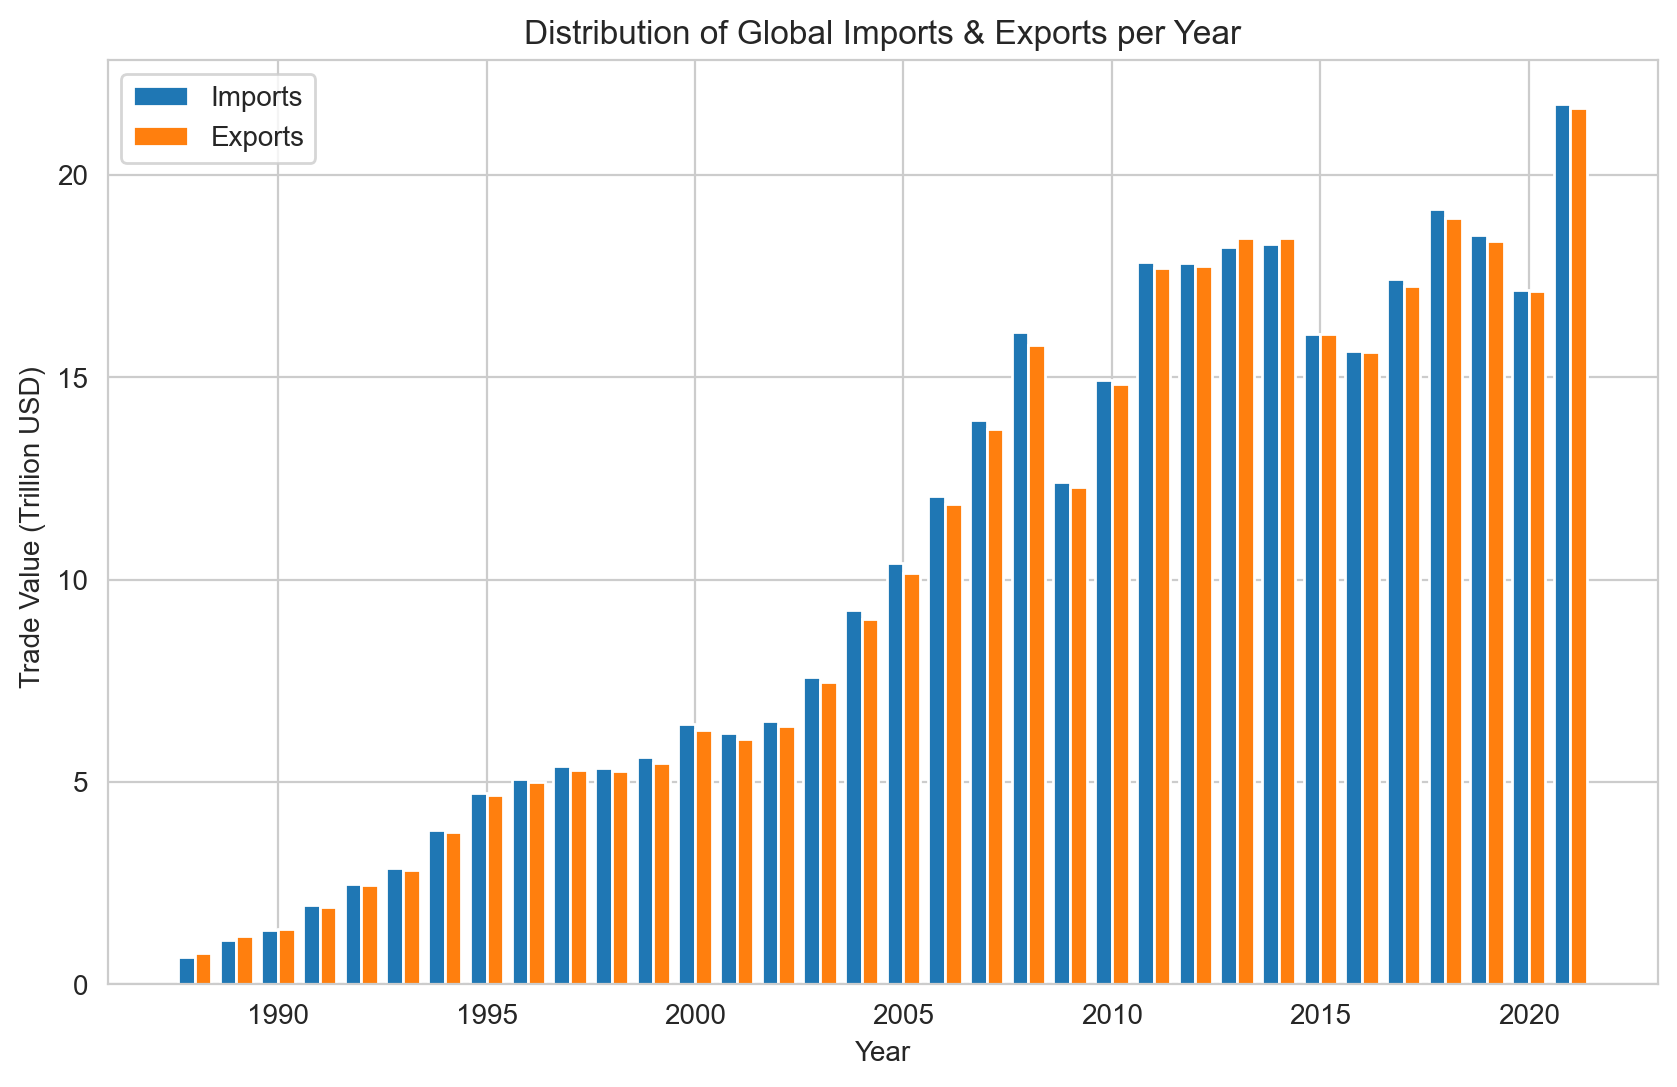

In [51]:
# Plotting a specific countries imports and exports
country = 'GBR'
country_total_trade_df = total_trade_df[total_trade_df['reporter'] == country].groupby('year').agg(total_exports=pd.NamedAgg(column='total_exports', aggfunc='sum'),total_imports=pd.NamedAgg(column='total_imports', aggfunc='sum')).reset_index()

plt.figure(figsize=(10,6))
#country_total_trade_df.plot(kind = 'bar', stacked = True, x='year', y=['total_exports','total_imports'], ax=plt.gca())
plt.bar(country_total_trade_df['year'].unique() - 0.2, (country_total_trade_df['total_exports'] /1e9), 0.4, label='Exports')
plt.bar(country_total_trade_df['year'].unique() + 0.2, (country_total_trade_df['total_imports'] /1e9), 0.4, label='Imports')
plt.xlabel("Year")
plt.ylabel("Trade Value (Trillion USD) ")
#plt.title("UK's Imports & Exports per Year")
plt.legend()
plt.show()

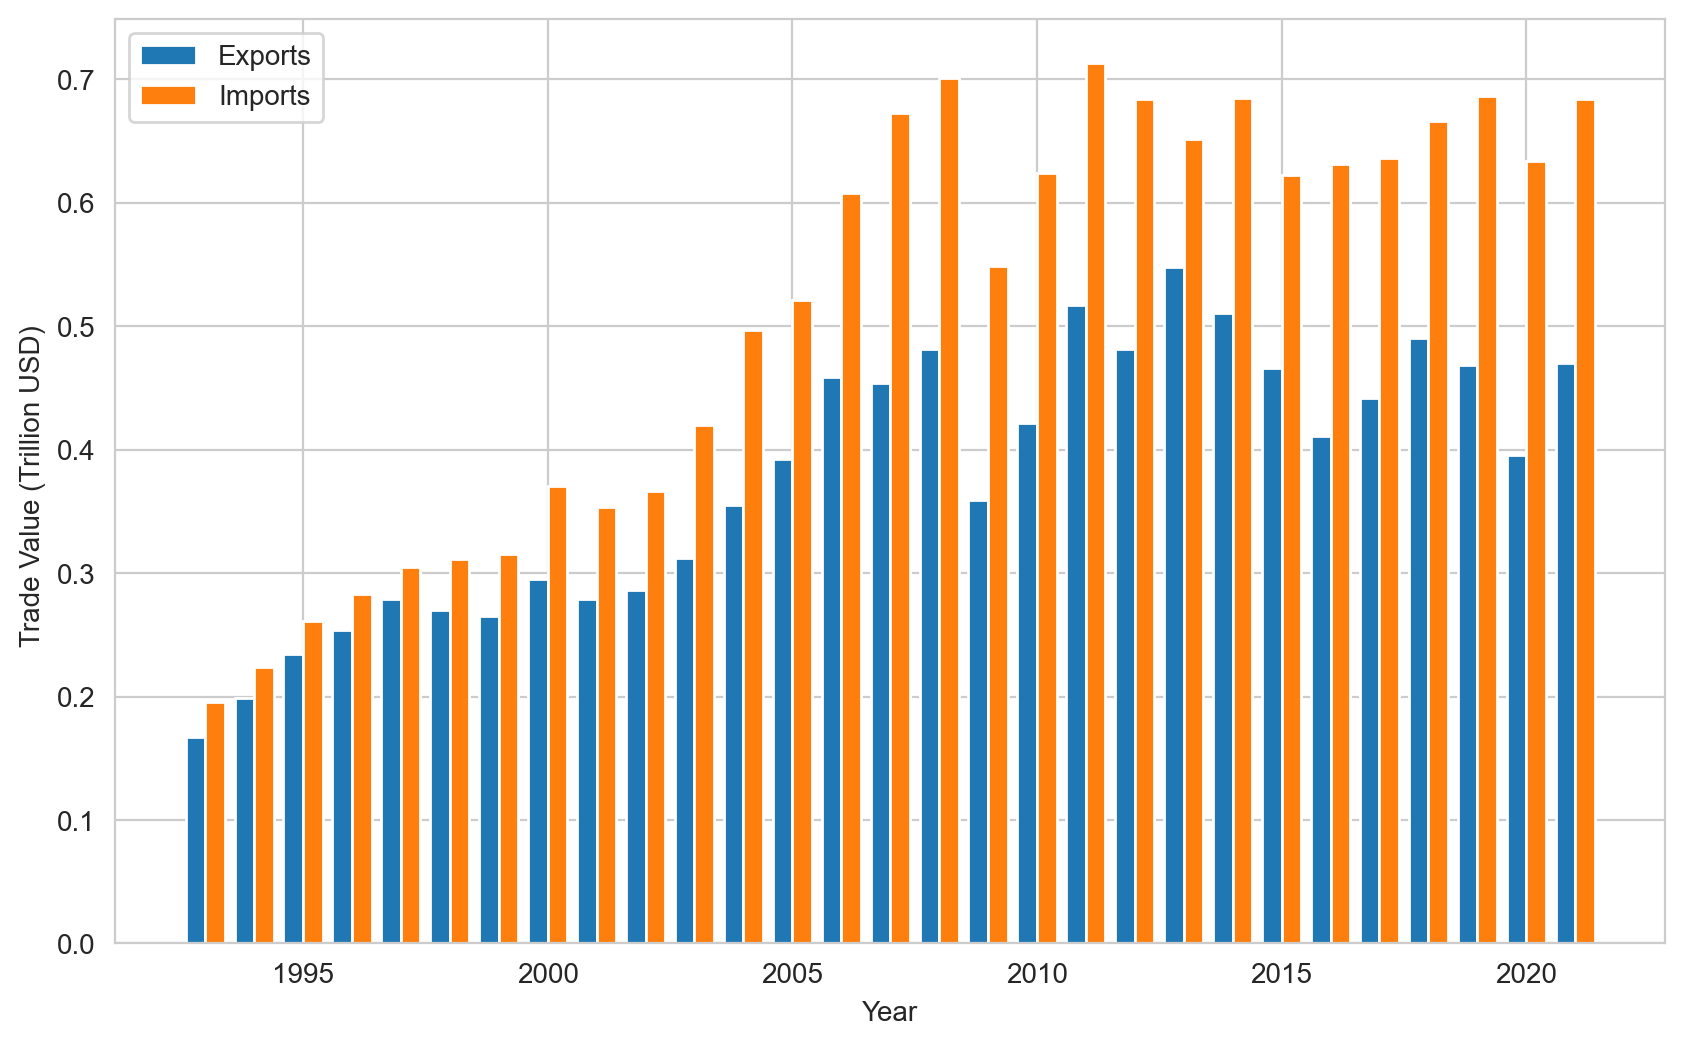

In [52]:
# Plotting a specific countries imports and exports
country1 = 'GBR'
name1 = 'United Kingdom'
country2 = 'CHN'
name2 = 'China'
country1_total_trade_df = total_trade_df[total_trade_df['reporter'] == country1].groupby('year').agg(total_exports=pd.NamedAgg(column='total_exports', aggfunc='sum'),total_imports=pd.NamedAgg(column='total_imports', aggfunc='sum')).reset_index()
country2_total_trade_df = total_trade_df[total_trade_df['reporter'] == country2].groupby('year').agg(total_exports=pd.NamedAgg(column='total_exports', aggfunc='sum'),total_imports=pd.NamedAgg(column='total_imports', aggfunc='sum')).reset_index()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))

#country_total_trade_df.plot(kind = 'bar', stacked = True, x='year', y=['total_exports','total_imports'], ax=plt.gca())
ax1.bar(country1_total_trade_df['year'].unique() - 0.2, (country1_total_trade_df['total_exports'] /1e9), 0.4, label='Exports')
ax1.bar(country1_total_trade_df['year'].unique() + 0.2, (country1_total_trade_df['total_imports'] /1e9), 0.4, label='Imports')
ax1.set_xlabel("Year")
ax1.set_ylabel("Trade Value (Trillion USD) ")
ax1.set_title(f"{name1}'s Imports & Exports per Year")
ax1.legend()
#plt.title("UK's Imports & Exports per Year")
ax2.bar(country2_total_trade_df['year'].unique() - 0.2, (country2_total_trade_df['total_exports'] /1e9), 0.4, label='Exports')
ax2.bar(country2_total_trade_df['year'].unique() + 0.2, (country2_total_trade_df['total_imports'] /1e9), 0.4, label='Imports')
ax2.set_xlabel("Year")
ax2.set_ylabel("Trade Value (Trillion USD) ")
ax2.legend()
ax2.set_title(f"{name2}'s Imports & Exports per Year")
#plt.title("UK's Imports & Exports per Year")
plt.show()

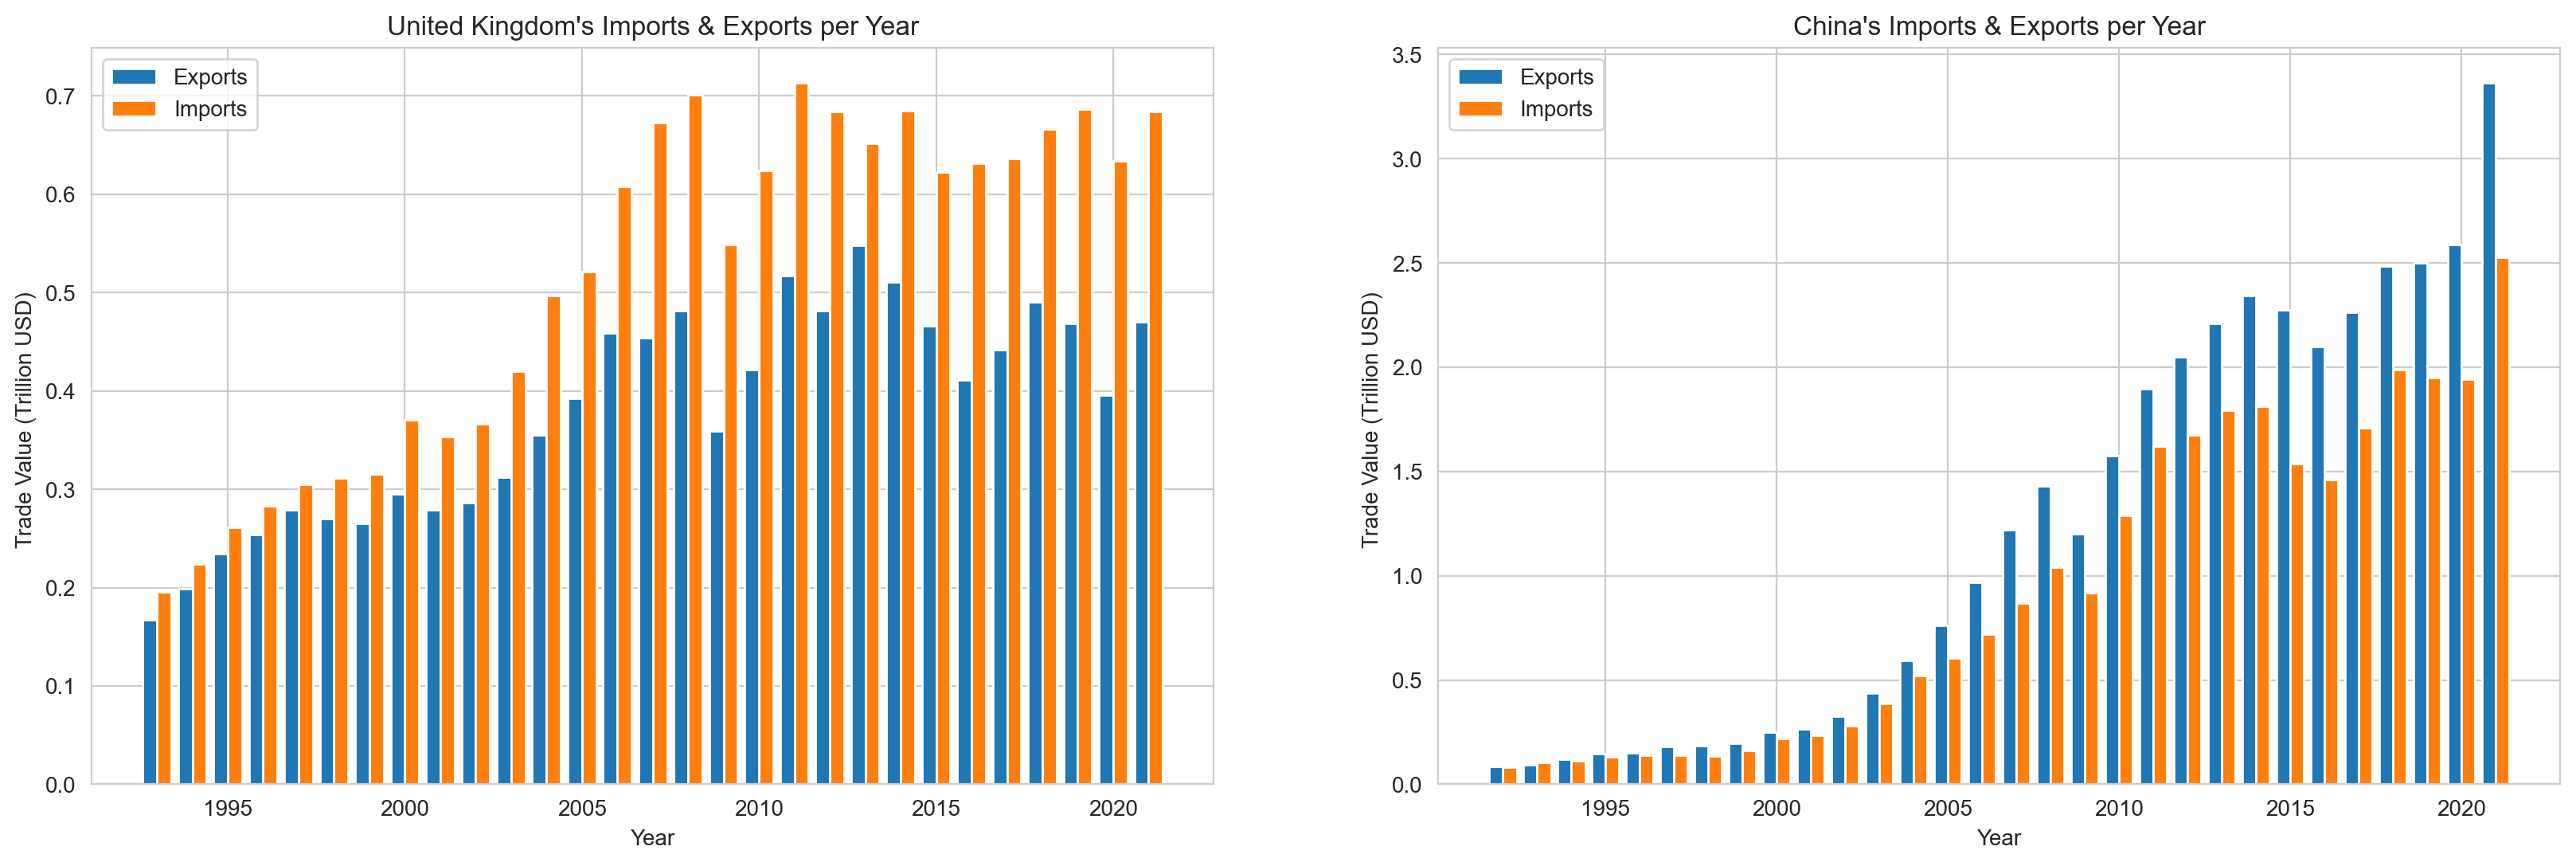

In [53]:
# Plotting a specific countries imports and exports
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,8))

#country_total_trade_df.plot(kind = 'bar', stacked = True, x='year', y=['total_exports','total_imports'], ax=plt.gca())
ax1.plot(country1_total_trade_df['year'].unique(), (country1_total_trade_df['total_exports'] /1e9), label='Exports', color=cb.quantitative['grepur'][0], linewidth=2)
ax1.plot(country1_total_trade_df['year'].unique(), (country1_total_trade_df['total_imports'] /1e9), label='Imports', color=cb.quantitative['grepur'][1], linestyle='--', linewidth=2)
ax1.set_xlabel("Year")
ax1.set_ylabel("Trade Value (Trillion USD) ")
ax1.set_title(f"{name1}'s Imports & Exports per Year")
ax1.legend(fontsize='large')
ax1.set_ylim(0,3.5)
#plt.title("UK's Imports & Exports per Year")
ax2.plot(country2_total_trade_df['year'].unique(), (country2_total_trade_df['total_exports'] /1e9), label='Exports', color=cb.quantitative['grepur'][0], linewidth=2)
ax2.plot(country2_total_trade_df['year'].unique(), (country2_total_trade_df['total_imports'] /1e9), label='Imports', color=cb.quantitative['grepur'][1], linestyle='--', linewidth=2)
ax2.set_xlabel("Year")
ax2.set_ylabel("Trade Value (Trillion USD) ")
ax2.legend(fontsize='large')
ax2.set_title(f"{name2}'s Imports & Exports per Year")

#plt.title("UK's Imports & Exports per Year")
plt.show()

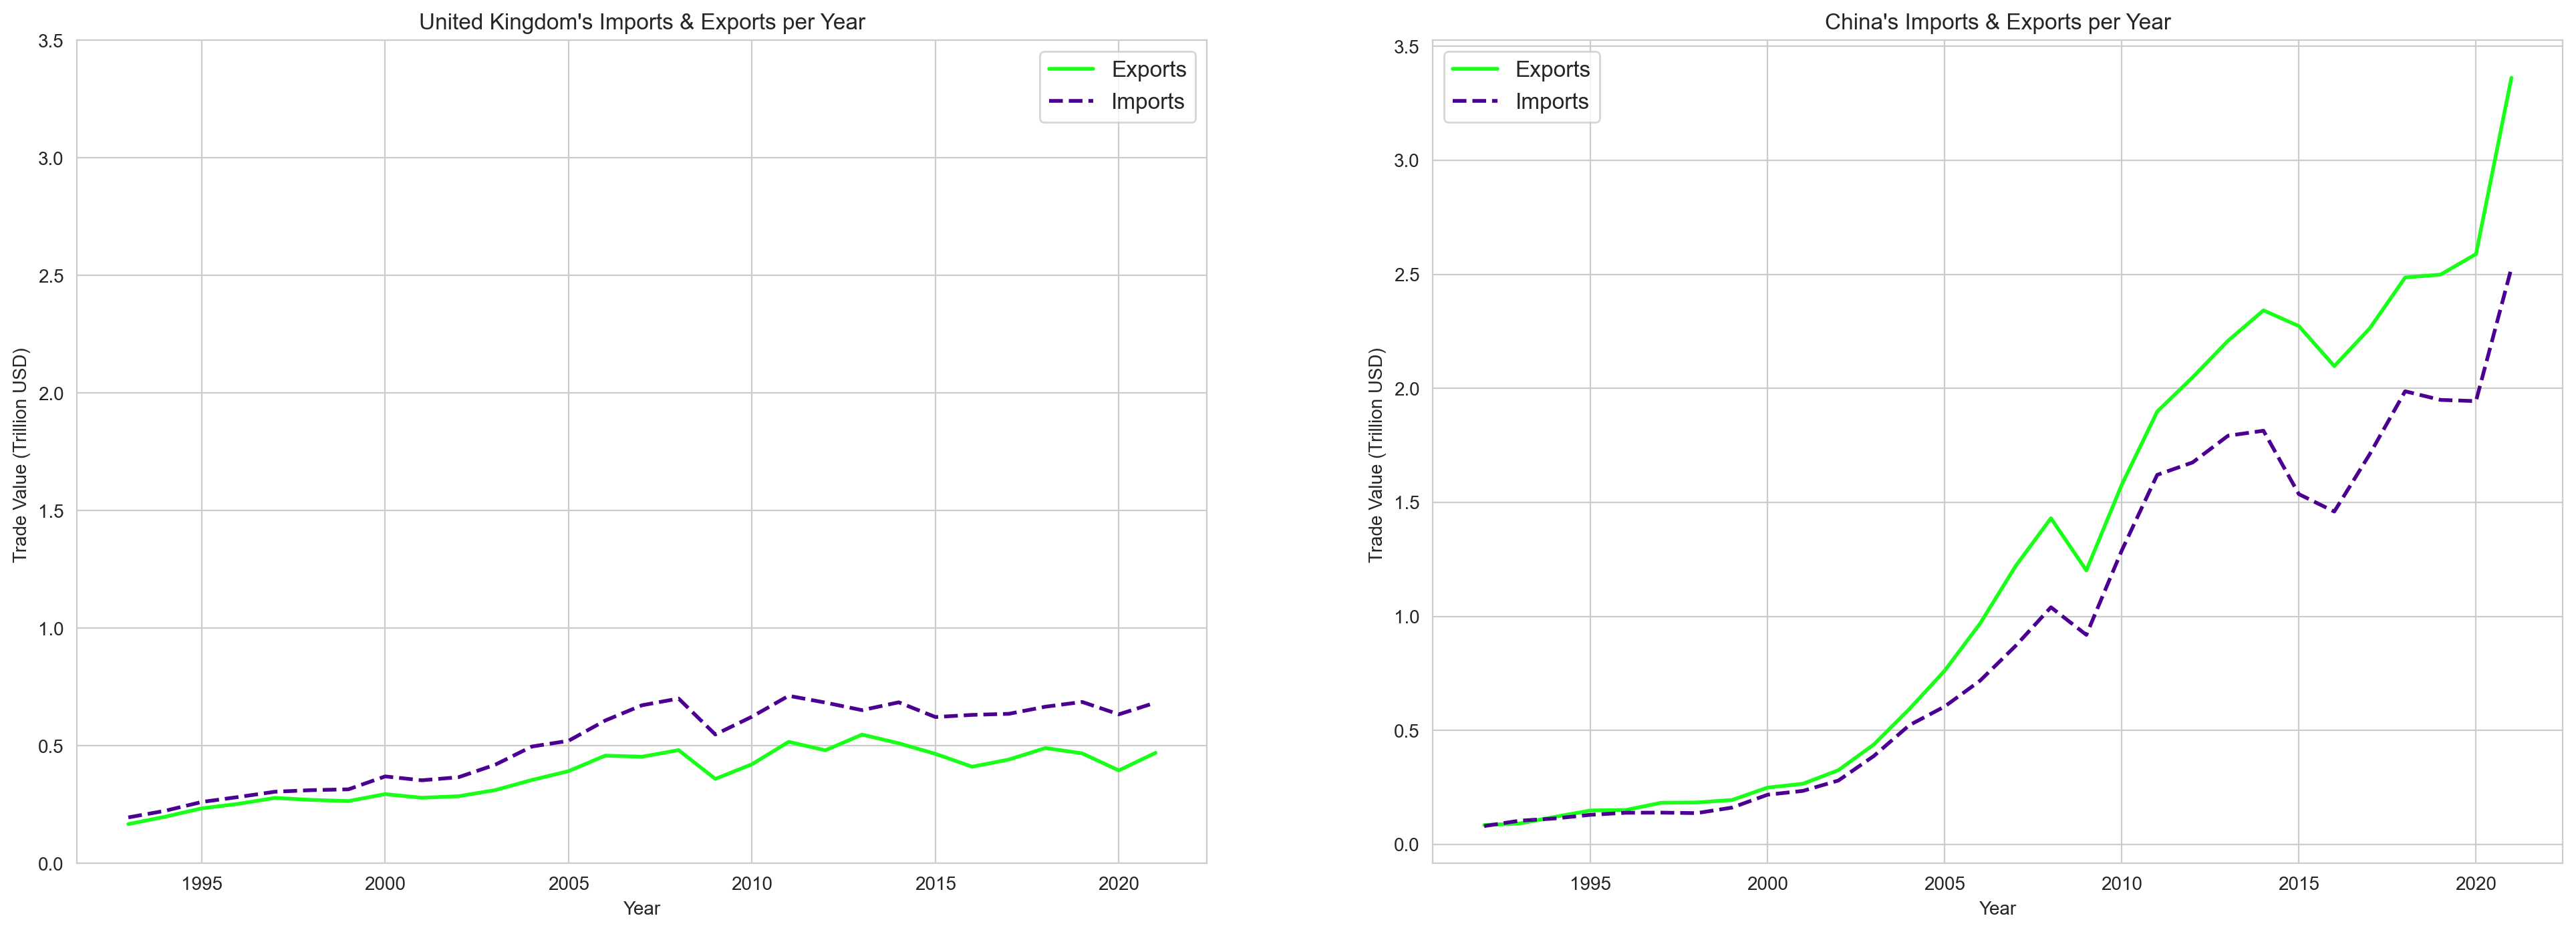

In [54]:
"""Find net trade for each country per year.
If X>M then there is a trade surplus, if X<M then there is a trade deficit."""

net_trade_df = pd.DataFrame({'year': total_trade_df['year'], 'reporter_iso': total_trade_df['reporter'], 'net_trade': total_trade_df['total_exports'] - total_trade_df['total_imports']})

#net_import_df = pd.DataFrame({'year': total_trade_df['year'], 'reporter_iso': total_trade_df['reporter'], 'net_trade': total_trade_df['total_imports'] - total_trade_df['total_exports']})

In [55]:
""" Plotting the global net trade per year
    Surplus is shown in green, deficit in red.
    To create this two plots are created and overlapped to look like a single plot. """

# Calculate yearly net trade
yearly_net_trade = net_trade_df.groupby('year')['net_trade'].sum()/1e6

# Setup plot
fig, ax = plt.subplots(figsize=(10,4))
yearly_neg = []  # List of DataFrames to plot for deficit
yearly_pos = []  # List of DataFrames to plot for surplus
order = ''  # The correct order plots to be drawn so they overlap correctly

# Looping through and determining if a new surplus or deficit plot should be created or extended
for year in yearly_net_trade.index:
    # Deficit
    if yearly_net_trade[year] < 0:
        # If plot doesn't exist, create one
        if len(yearly_neg) == 0:
            order += 'n'
            yearly_neg.append(pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0]))
            # If previous plot is surplus, extend to make graphs look connected
            if len(yearly_pos) > 0:
                yearly_pos[-1] = pd.concat([yearly_pos[-1],pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0])])
        # Extend plot
        elif yearly_neg[-1]['year'].values[-1] == year-1:
            yearly_neg[-1] = pd.concat([yearly_neg[-1],pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0])])
        # Start of a new deficit
        else:
            order += 'n'
            yearly_pos[-1] = pd.concat([yearly_pos[-1],pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0])])
            yearly_neg.append(pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0]))
    # Surplus
    else:
        # If plot doesn't exist, create one
        if len(yearly_pos) == 0:
            order += 'p'
            yearly_pos.append(pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0]))
            # If previous plot is deficit, extend to make graphs look connected
            if (len(yearly_neg) > 0):
                yearly_neg[-1] = pd.concat([yearly_neg[-1],pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0])])
        # Extend plot
        elif yearly_pos[-1]['year'].values[-1] == year-1:
            yearly_pos[-1] = pd.concat([yearly_pos[-1],pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0])])
        # Start of a new surplus
        else:
            order += 'p'
            yearly_neg[-1] = pd.concat([yearly_neg[-1],pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0])])
            yearly_pos.append(pd.DataFrame({'year':year, 'net_trade':yearly_net_trade[year]}, index=[0]))

# Plotting in order to make a single connected graph of varying colours
nindex = 0
pindex = 0
for o in order:
    if o == 'p':
        plot = yearly_pos[pindex]
        ax.plot(plot['year'], plot['net_trade'], color=cb.quantitative['blupnk'][0], marker='D', mfc='w', linewidth=2)
        pindex += 1
    else:
        plot = yearly_neg[nindex]
        ax.plot(plot['year'], plot['net_trade'], color=cb.quantitative['blupnk'][1], marker='D', mfc='w', linewidth=2)
        nindex += 1

plt.xlabel('Year')
plt.ylabel('Net Trade Value (Billion USD)')
#plt.title('Global Net Trade by Year')
plt.legend(['Surplus','Deficit'], fontsize='large')
plt.ylim(-350,350)

plt.show()

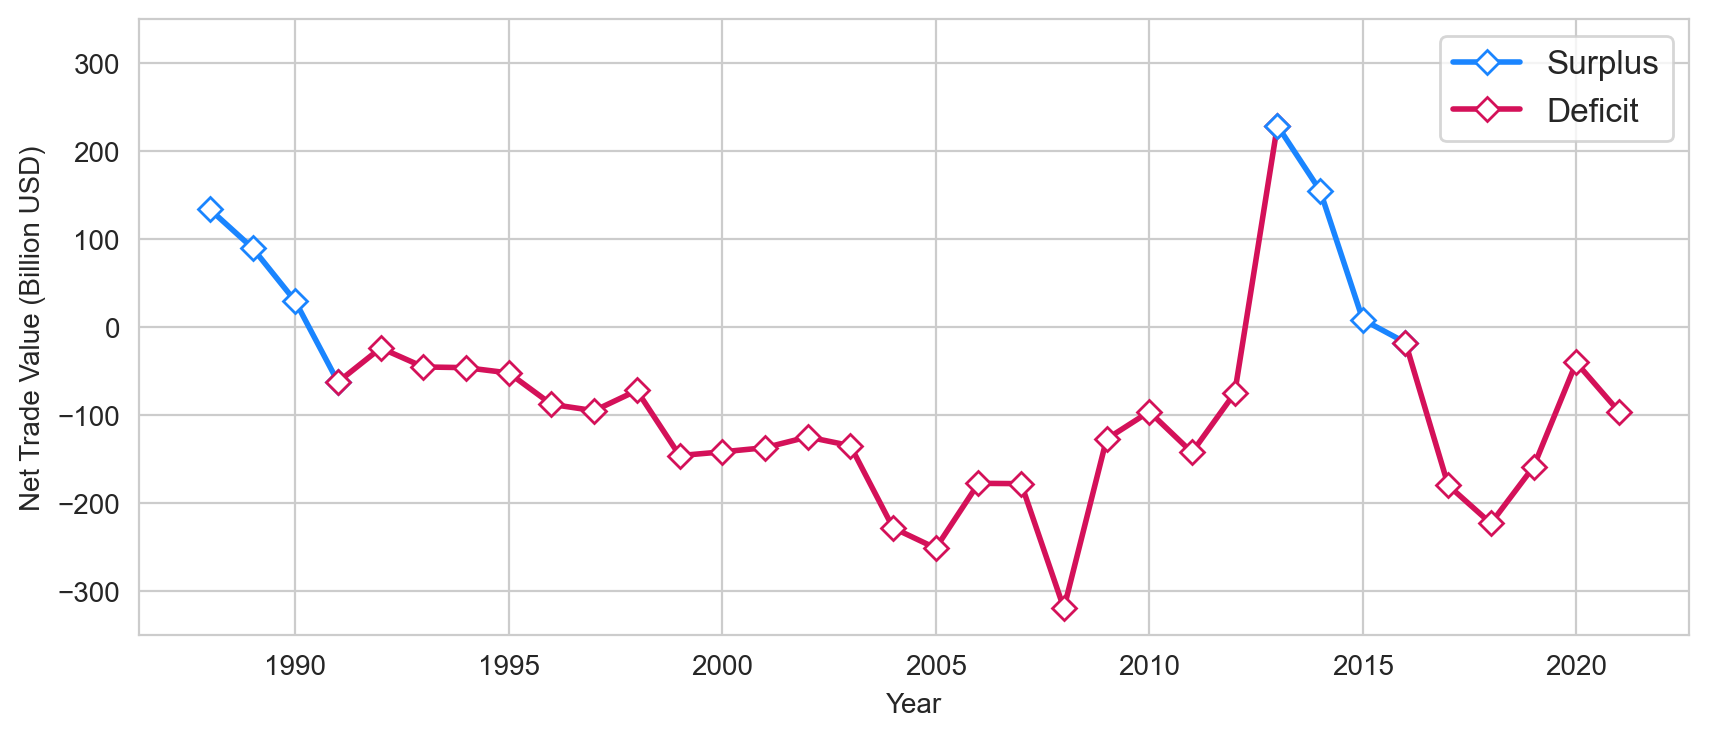

In [56]:
# Single country's trade over time
country = 'DEU'

country_total_trade_df = total_trade_df[total_trade_df['reporter'] == country]
country_total_trade_df
# Plot the data
plt.plot(country_total_trade_df['year'], country_total_trade_df['total_exports']/1e6, label='Exports')
plt.plot(country_total_trade_df['year'], country_total_trade_df['total_imports']/1e6, label='Imports')

# Add labels
plt.xlabel('Year')
plt.ylabel('Trade Value USD$ Billions')
plt.title('Trade Value by Year')
plt.legend()

# Show the plot
plt.show()

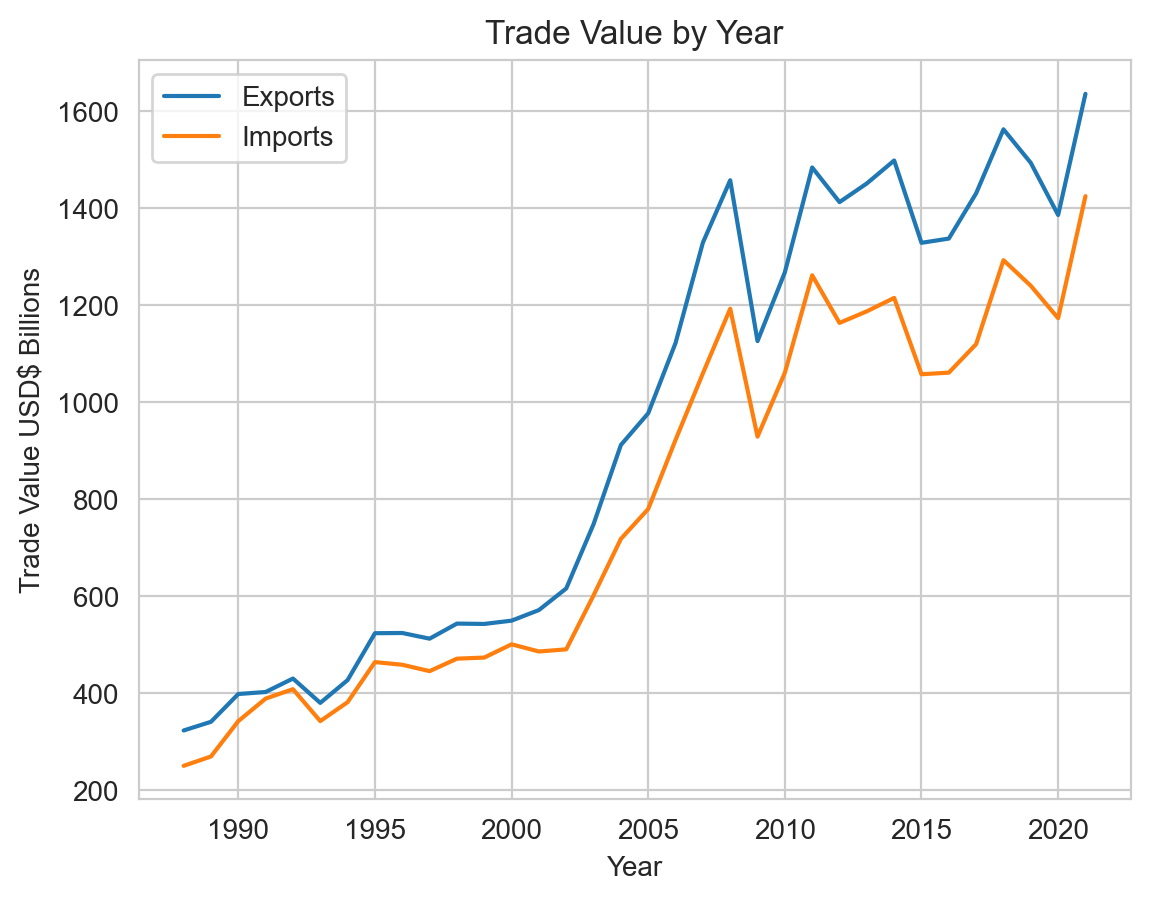

In [57]:
# Creates a DataFrame with countries ranked by their number of partners for each year
ranking_df = pd.DataFrame()
for year in np.sort(countries_df['year'].unique()):
    ranking_df = pd.concat([ranking_df,countries_df[countries_df['year'] == year].groupby('reporter')['partner'].nunique().rename(year)], axis=1)
ranking_df.rename_axis('reporter', inplace=True)
ranking_df = ranking_df.fillna(0)
rank_names = list(ranking_df.index)

# Gets the top 10 countries for each year
top_10 = []
plt.figure(figsize=(10, 6))
plots = {}
for year in ranking_df.columns:
    rankings = ranking_df[year].nlargest(10).rename(year)
    for index, rank in rankings.items():
        plots[index] = plots.get(index, []) + [{year:rank}]

for country, point in plots.items():
    country_year = []
    country_partners = []
    for i in point:
        country_year.append(list(i.keys())[0])
        country_partners.append(list(i.values())[0])
    plt.plot(country_year, country_partners, label=country)


plt.legend()
plt.ylim(170)
plt.show()
plots

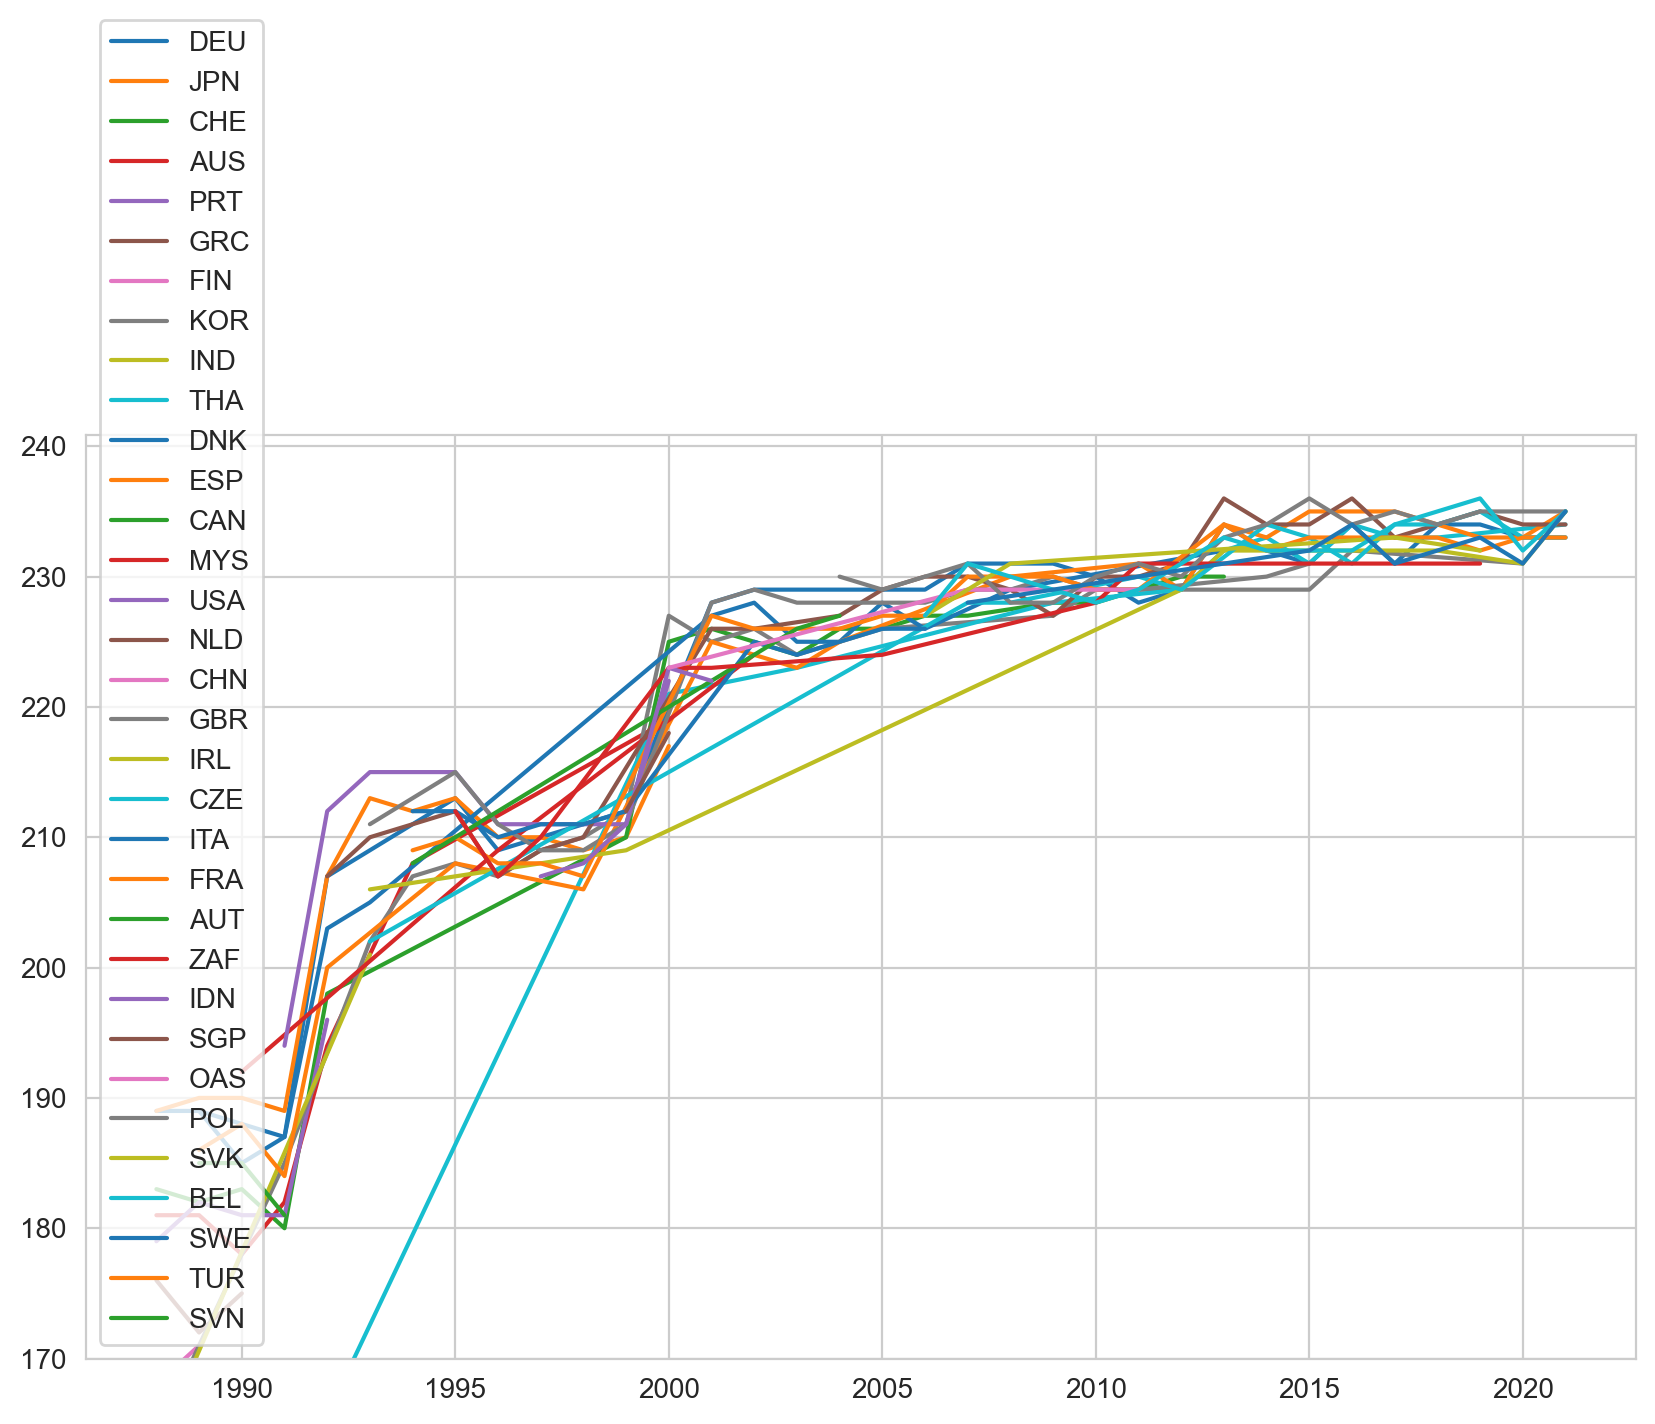

{'DEU': [{1988: 189.0},
  {1989: 189.0},
  {1990: 188.0},
  {1991: 187.0},
  {1992: 207.0},
  {1993: 209.0},
  {1994: 211.0},
  {1995: 213.0},
  {1996: 209.0},
  {1997: 210.0},
  {1998: 211.0},
  {1999: 212.0},
  {2001: 228.0},
  {2002: 229.0},
  {2003: 229.0},
  {2004: 229.0},
  {2005: 229.0},
  {2006: 229.0},
  {2007: 231.0},
  {2008: 231.0},
  {2009: 231.0},
  {2010: 230.0},
  {2011: 228.0},
  {2012: 229.0},
  {2013: 234.0},
  {2014: 232.0},
  {2015: 231.0},
  {2016: 234.0},
  {2017: 231.0},
  {2018: 234.0},
  {2019: 234.0},
  {2020: 233.0},
  {2021: 233.0}],
 'JPN': [{1988: 189.0},
  {1989: 190.0},
  {1990: 190.0},
  {1991: 189.0},
  {1992: 207.0},
  {1993: 213.0},
  {1994: 212.0},
  {1995: 213.0},
  {1996: 210.0},
  {1997: 210.0},
  {1998: 209.0},
  {1999: 210.0},
  {2000: 217.0}],
 'CHE': [{1988: 183.0},
  {1989: 182.0},
  {1990: 183.0},
  {1991: 180.0},
  {1992: 198.0},
  {1999: 210.0},
  {2000: 225.0},
  {2001: 226.0},
  {2002: 225.0},
  {2003: 224.0},
  {2004: 226.0},
  {2005:

In [58]:
# Making previous graph readable by making y axis rank
number_of_countries = 5
rankings_dict = {}
for year in ranking_df.columns:
    rank = 1
    for country in ranking_df[year].nlargest(number_of_countries).rank(ascending=False).index:
        rankings_dict[country] = rankings_dict.get(country, []) + [{year:rank}]
        rank+=1

for country, point in rankings_dict.items():
    country_year = []
    country_partners = []
    for i in point:
        country_year.append(list(i.keys())[0])
        country_partners.append(list(i.values())[0])
    plt.plot(country_year, country_partners, label=country)

plt.legend()
plt.show()

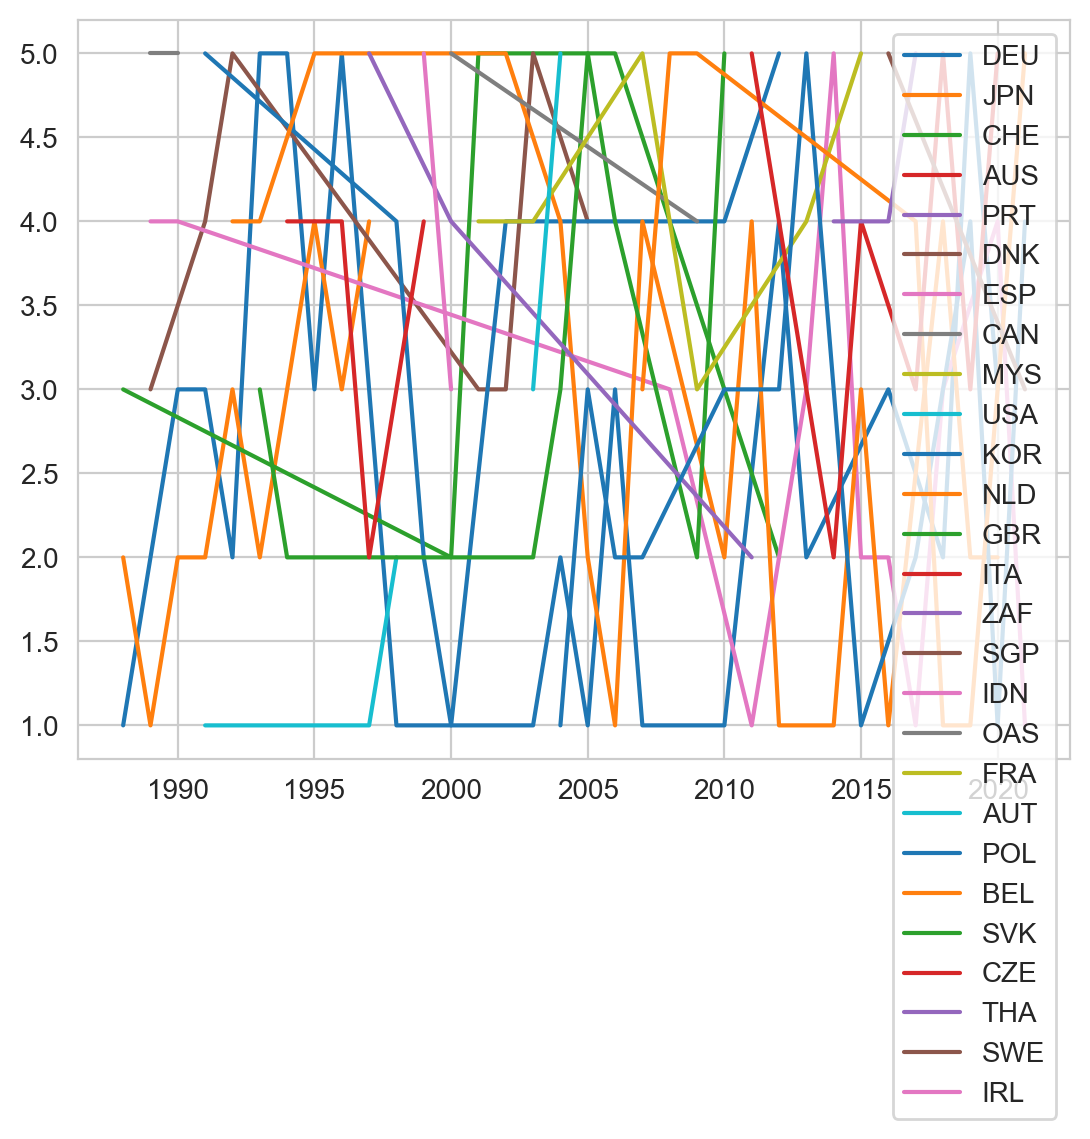

In [59]:
# Making previous graph readable by only including top x in 2021
number_of_countries = 10
year = 2021
rankings_top = ranking_df[year].nlargest(number_of_countries)
plt.figure(figsize=(10, 6))
rankings_dict = {}
for year in ranking_df.columns:
    rank = 1
    for country in ranking_df.loc[rankings_top.index][year].sort_values(ascending=False).index:
        rankings_dict[country] = rankings_dict.get(country, []) + [{year:rank}]
        rank+=1

for country, point in rankings_dict.items():
    country_year = []
    country_partners = []
    for i in point:
        country_year.append(list(i.keys())[0])
        country_partners.append(list(i.values())[0])
    plt.plot(country_year, country_partners, label=country)

plt.legend()
plt.show()

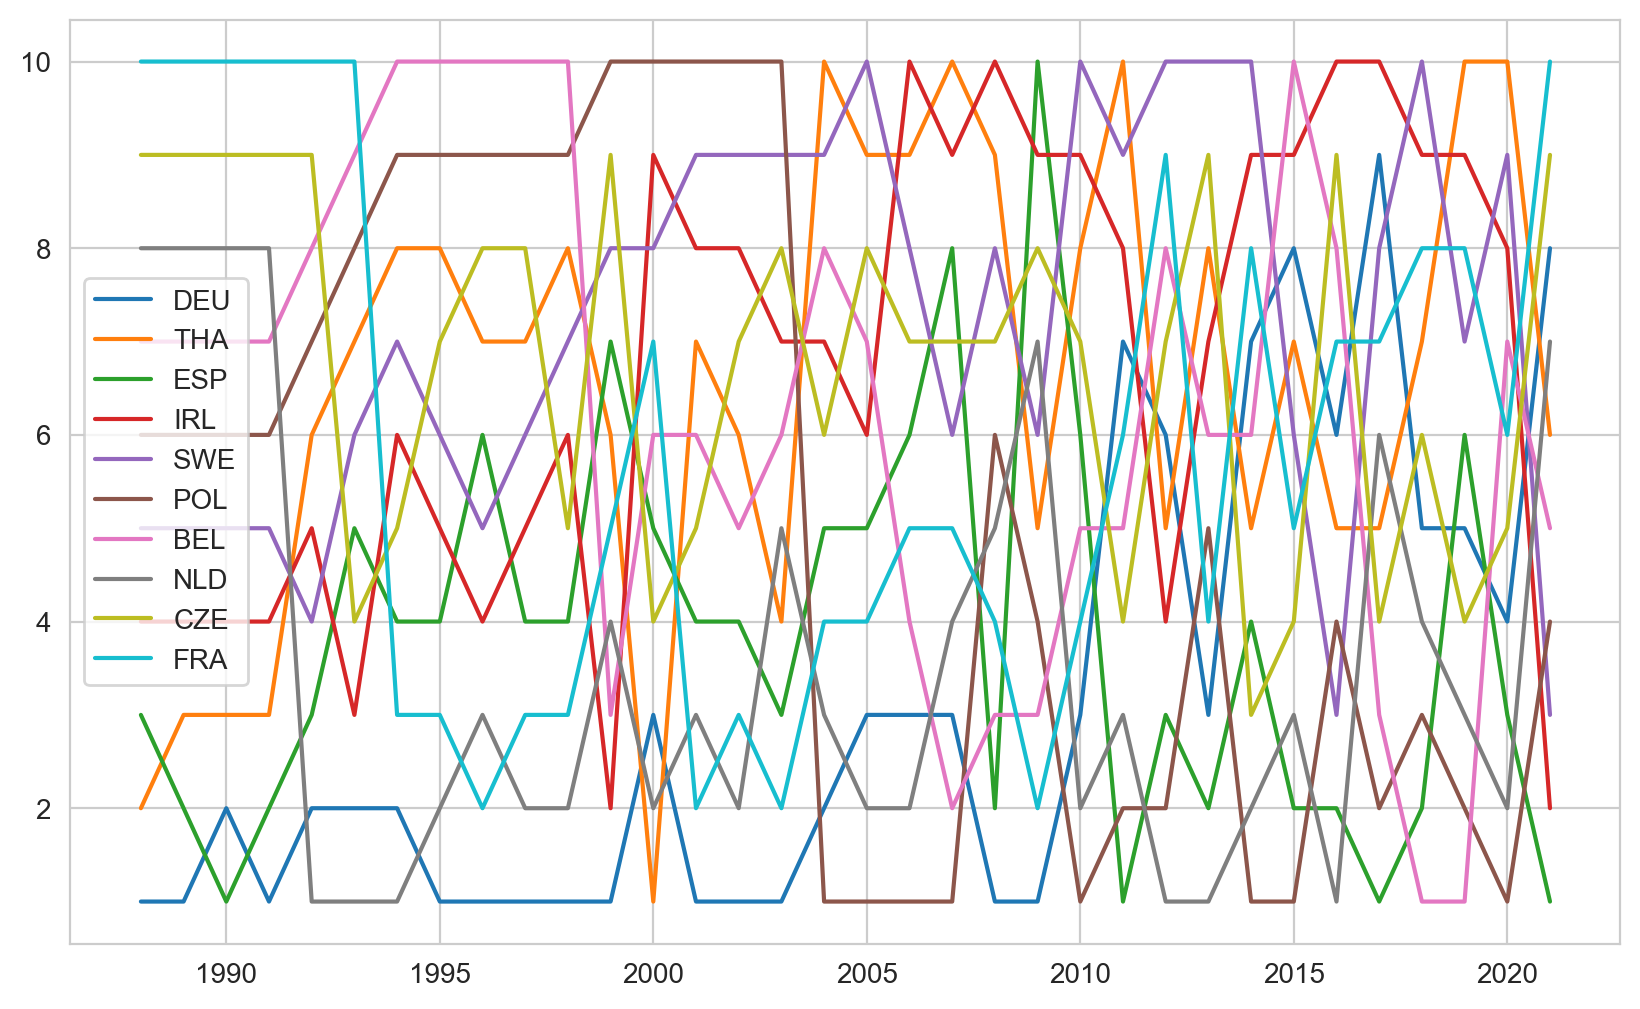

In [60]:
""" Calculating ranks by number of trading partners """

# Creates a DataFrame with the number of trading partners for a state per year
no_partners = pd.DataFrame()
for year in sorted(countries_df['year'].unique()):
    no_partners = pd.concat([no_partners, countries_df[countries_df['year'] == year].groupby('reporter')['partner'].nunique().rename(year)], axis=1)

# Creates a DataFrame where each country is ranked by the number of trading partners it has
rank_partners = pd.DataFrame()
for year in no_partners.columns:
    rank_partners = pd.concat([rank_partners, no_partners[year].rank(ascending=False, method='dense')], axis=1)

# Creates a DataFrame of the top 10 countries per year, in an easier to plot format
top_partner_rank = pd.DataFrame()
for year in rank_partners.columns:
    # Top 10
    temp_df = rank_partners[year]
    top_partner_rank = pd.concat([top_partner_rank, pd.DataFrame(temp_df[temp_df < 11]).T])

top_10_partners = top_partner_rank.isnull().sum().sort_values().rank(method='first')
top_10_partners = top_10_partners[top_10_partners < 13]
top_10_partners_df = top_partner_rank[top_10_partners.index].T
top_10_partners_df

In [61]:
""" Bump Graph of Top Trading Partners
    This graph shows the top 10 trading partners, that were most present
    in the dataset. """

fig, ax = plt.subplots(figsize=(16, 6))

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(1))

#line_colours = ['b', 'g', 'r', 'c', 'm', 'y', 'tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'k']
line_style = '-'
i=0
for country, entry in top_10_partners_df.iterrows():
    if i == 10:
        i = 0
        line_style = '--'
    ax.plot(entry.index, entry.values, label=country, marker='o', mfc='w', color=cp('colorblind')[i], linestyle=line_style,
            linewidth=2)
    i+=1

ax.invert_yaxis()
plt.legend()
plt.ylabel('Rank')
plt.xlabel('Year')
plt.show()

1988  1989  1990  1991  1992  1993  1994  1995  1996  1997  ...  2012  \
DEU   1.0   2.0   3.0   3.0   2.0   5.0   4.0   2.0   3.0   2.0  ...   3.0   
KOR   7.0   NaN   NaN   4.0   9.0   8.0   7.0   5.0   5.0   3.0  ...   3.0   
ESP   NaN   3.0   3.0   5.0   4.0  10.0   8.0   5.0   NaN   6.0  ...   3.0   
DNK   NaN   2.0   4.0   3.0   3.0   7.0   7.0   6.0   6.0   7.0  ...   5.0   
NLD   NaN   NaN   NaN   NaN   2.0   4.0   4.0   3.0   5.0   3.0  ...   1.0   
GBR   NaN   NaN   NaN   NaN   NaN   3.0   2.0   1.0   1.0   3.0  ...   4.0   
CHE   2.0   5.0   5.0   8.0   5.0  10.0  10.0   NaN   NaN  10.0  ...   2.0   
ZAF   NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   5.0   2.0  ...   6.0   
FRA   NaN   NaN   NaN   NaN   NaN   NaN   5.0   4.0   4.0   4.0  ...   4.0   
USA   NaN   NaN   NaN   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   6.0   
THA   9.0   9.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   3.0   
ITA   NaN   NaN   NaN   NaN   NaN   NaN   3.0   3.0   2.0   1.0  ...   5.0   

     2013  2014  2015  2016  2017  2018  2019  2020  2021  
DEU   2.0   3.0   6.0   3.0   4.0   2.0   3.0   3.0   3.0  
KOR   5.0   7.0   7.0   5.0   8.0   5.0  10.0   5.0   4.0  
ESP   2.0   2.0   2.0   2.0   1.0   2.0   4.0   3.0   1.0  
DNK   4.0   7.0   9.0   8.0   8.0   9.0   NaN   9.0  10.0  
NLD   1.0   1.0   3.0   1.0   3.0   2.0   2.0   2.0   2.0  
GBR   5.0   4.0   6.0   7.0   4.0   5.0   7.0   5.0   5.0  
CHE   5.0   8.0   9.0   NaN   7.0   6.0   NaN   NaN   9.0  
ZAF   6.0   5.0   7.0   9.0   5.0   4.0   6.0   8.0   4.0  
FRA   2.0   3.0   4.0   4.0   3.0   3.0   5.0   3.0   3.0  
USA   9.0   9.0   NaN   NaN  10.0  10.0   NaN   NaN   NaN  
THA   4.0   2.0   6.0   3.0   3.0   3.0   8.0   7.0   2.0  
ITA   7.0   8.0   NaN  10.0   8.0  10.0   9.0   NaN  10.0  

[12 rows x 34 columns]

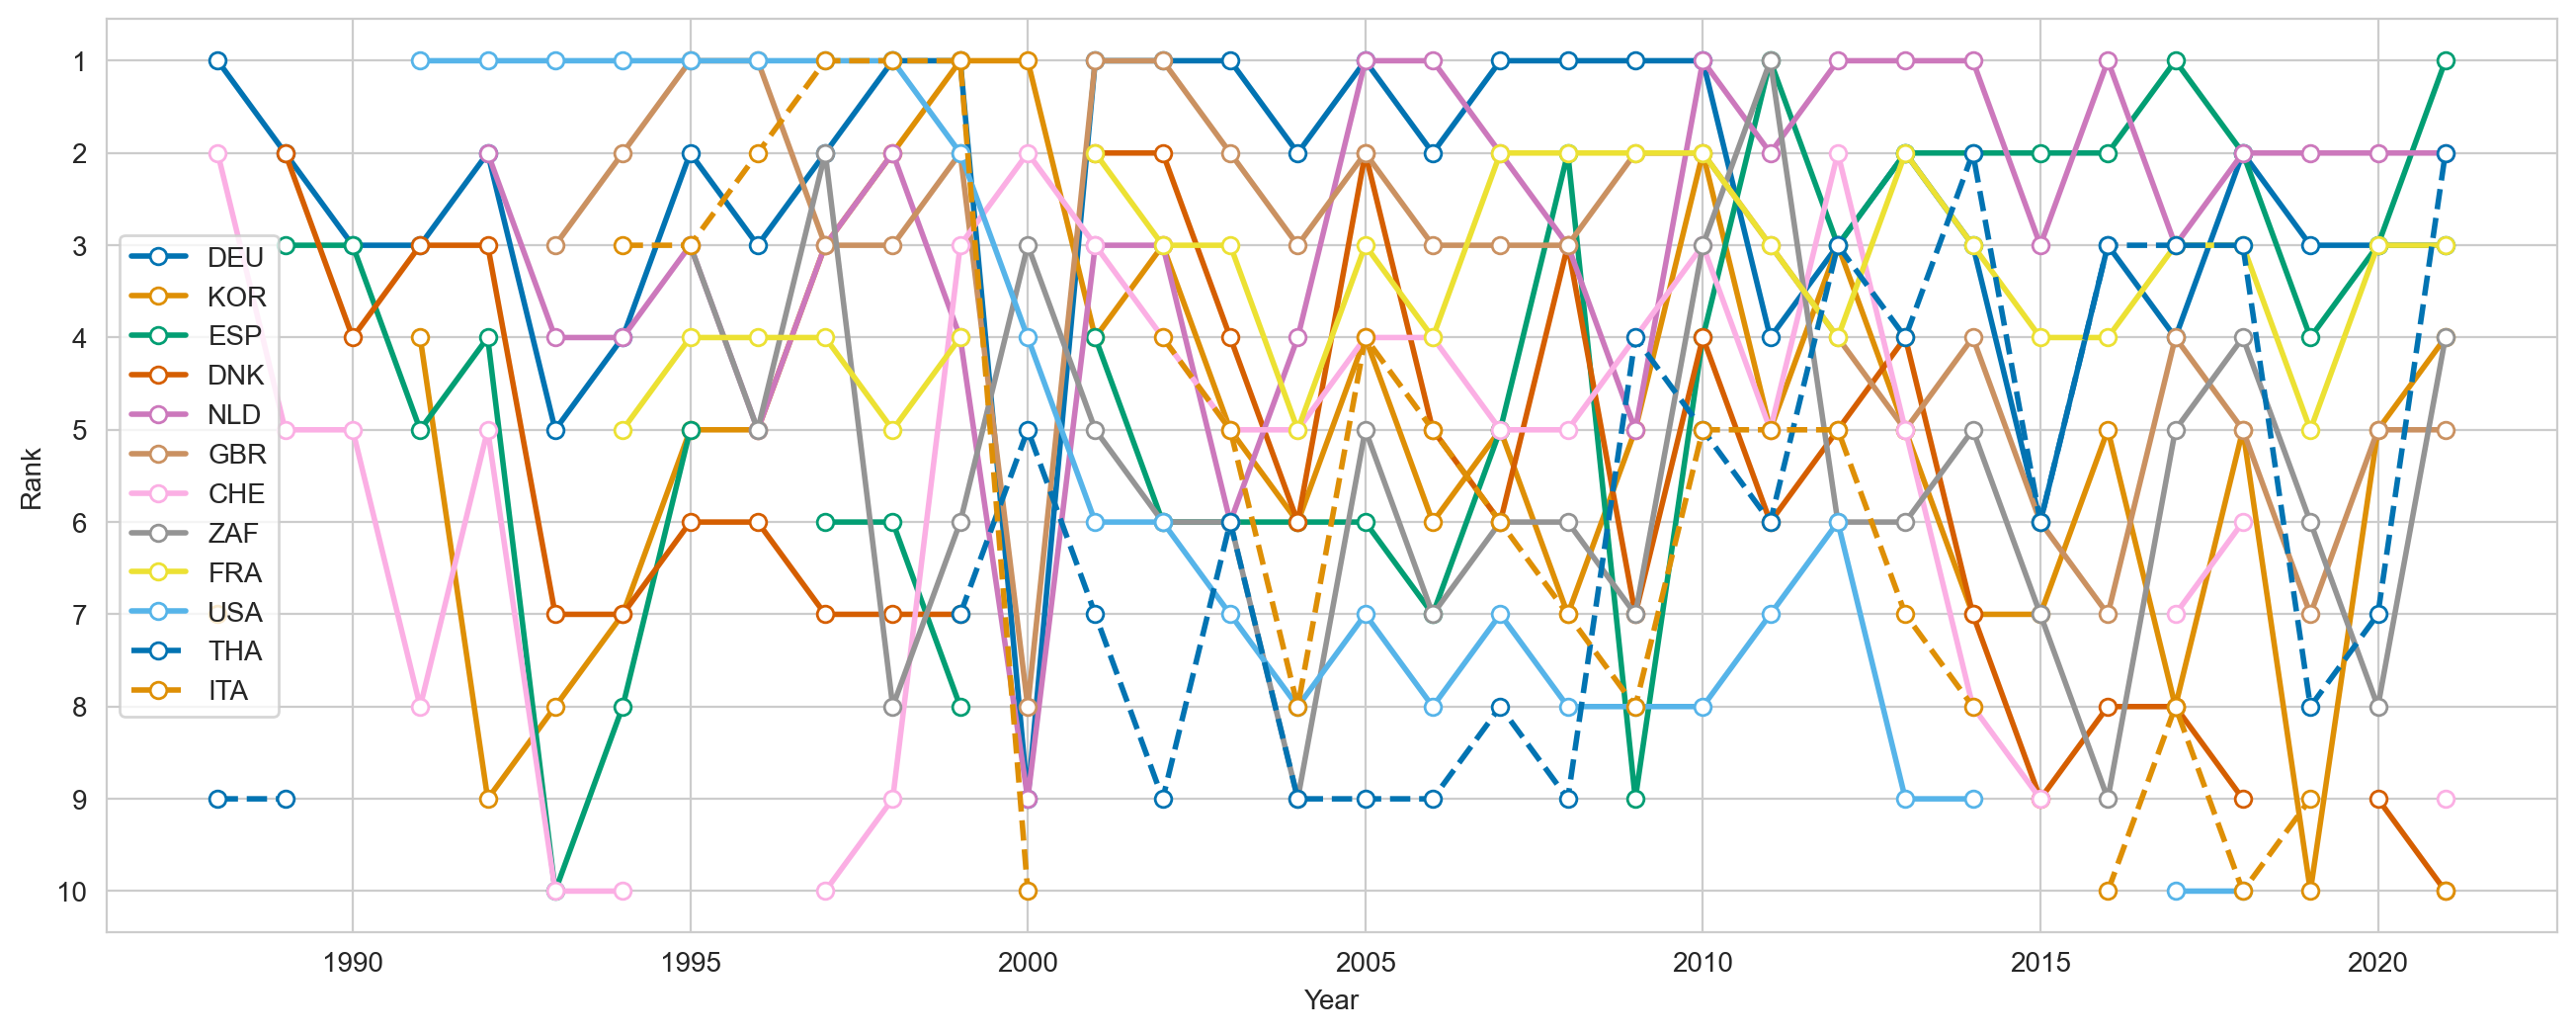

In [62]:
""" Bump Graph of Top Trading Parnters
This graph has a second axis which acts a legend.
The axis ranks out of 10 with the top 10 countries of 2021. """

# Making previous graph readable by only including top x in 2021
number_of_countries = 10
year = 2021
rankings_top = ranking_df[year].nlargest(number_of_countries).rank(ascending=False,method='first')
fig, ax = plt.subplots(figsize=(16, 6))

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(1))

# Second y axis
yax2 = ax.secondary_yaxis("right")
yax2.yaxis.set_major_locator(FixedLocator(list(rankings_top)))
yax2.yaxis.set_major_formatter(FixedFormatter(list(rankings_top.index)))

rankings_dict = {}
for year in ranking_df.columns:
    temp_df = ranking_df.loc[rankings_top.index][year].sort_values(ascending=False).rank(ascending=False, method='min').reset_index()
    for i, country in temp_df.iterrows():
        rankings_dict[country.values[0]] = rankings_dict.get(country.values[0], []) + [{year:i+1}]

for country, point in rankings_dict.items():
    country_year = []
    country_partners = []
    for i in point:
        country_year.append(list(i.keys())[0])
        country_partners.append(list(i.values())[0])
    plt.plot(country_year, country_partners, "o", mfc="w", label=country,
             linestyle='-')

ax.invert_yaxis()
ax.set(xlabel="Year", ylabel="Rank", title="Top 10 Countries by Number of Trading Partners")
#plt.legend()
ax.grid(axis="x")
#plt.tight_layout()
plt.show()

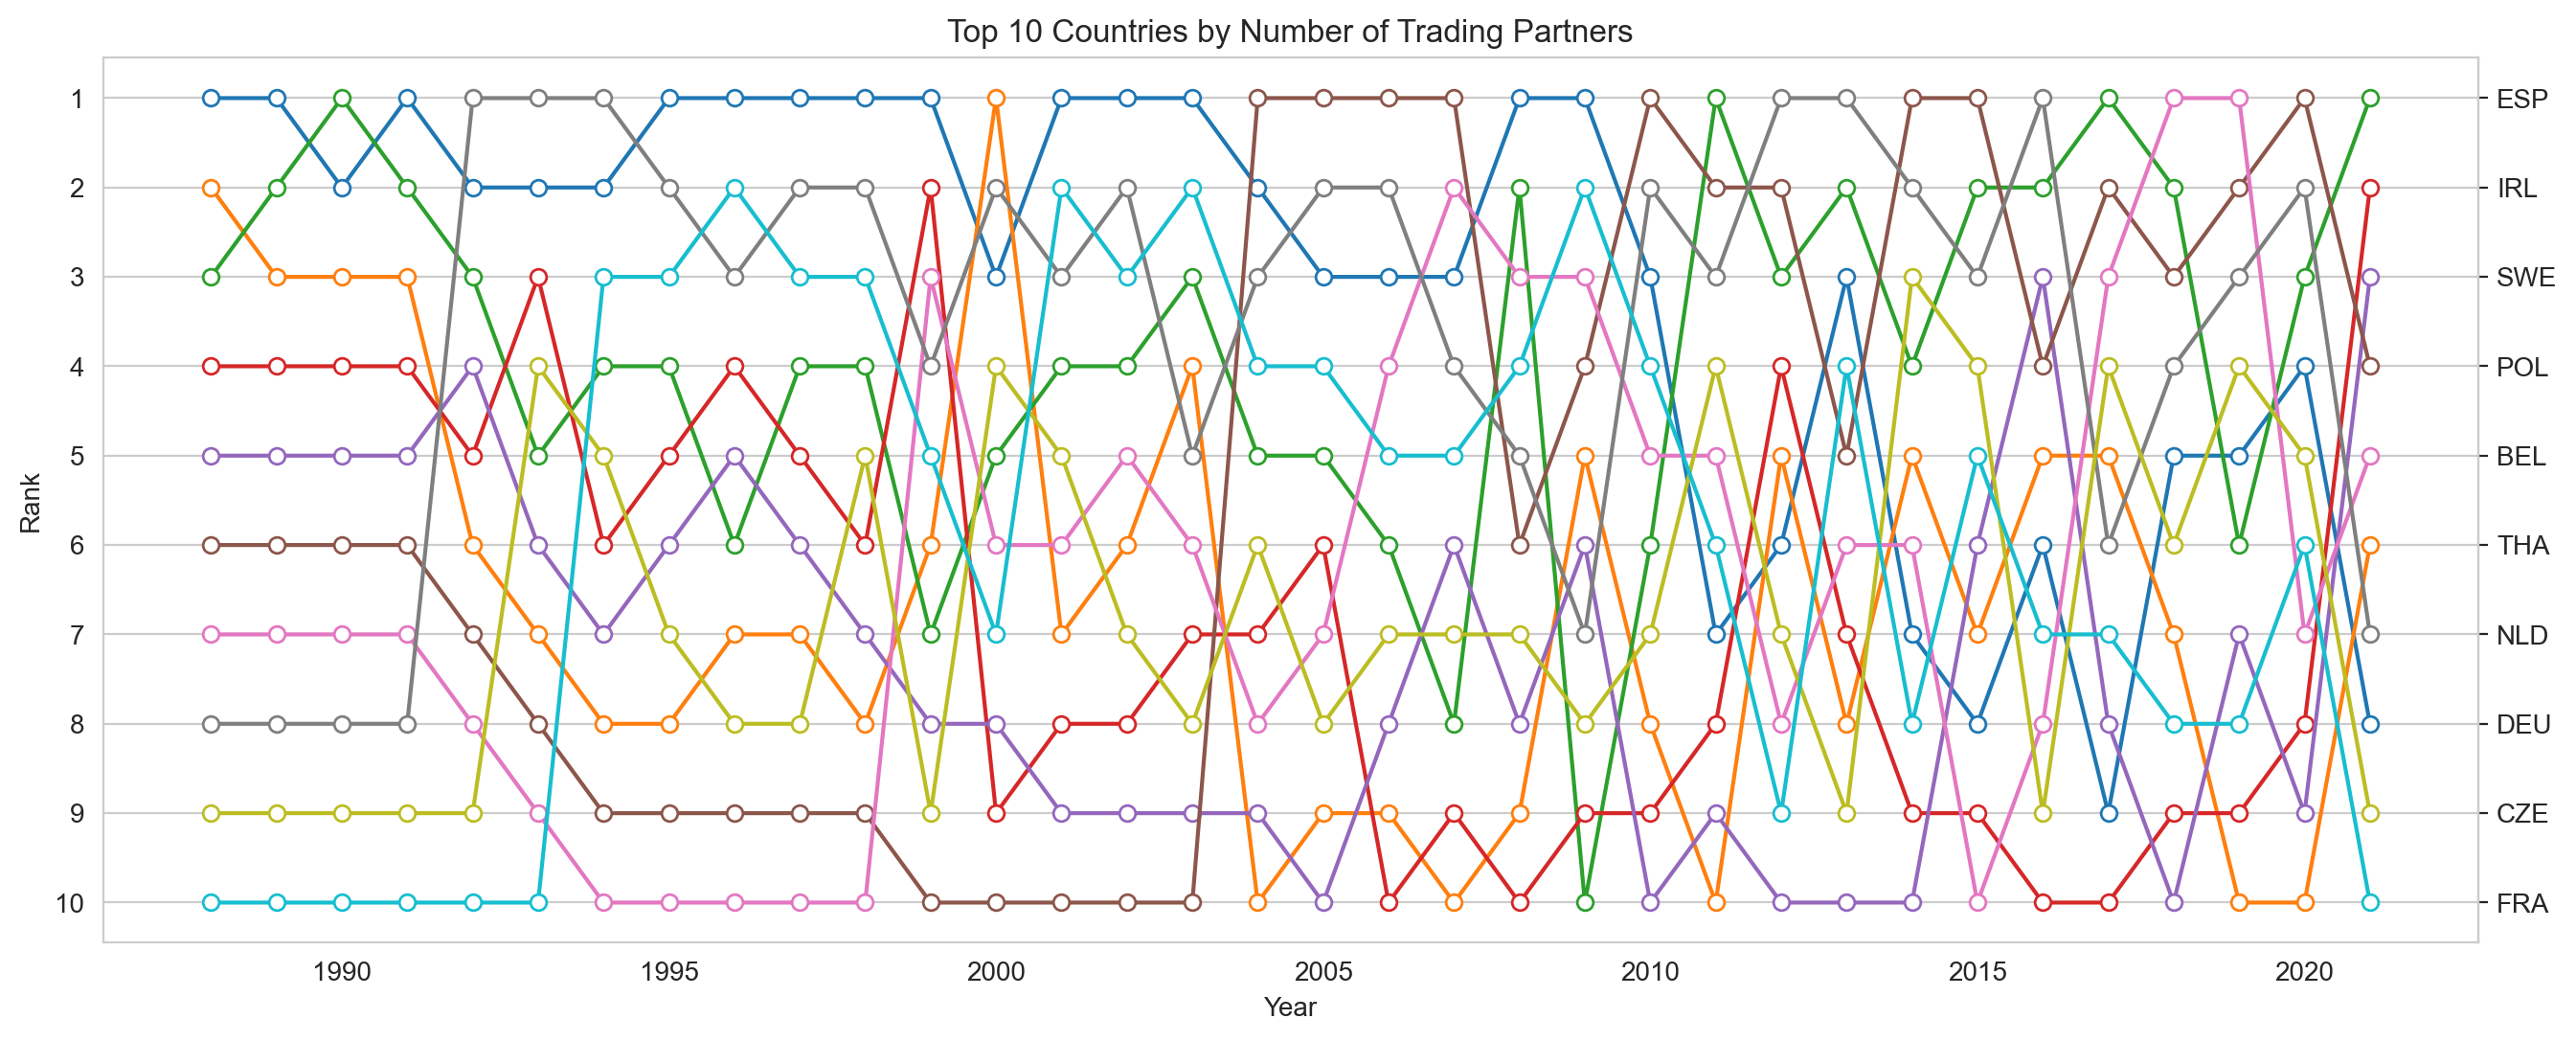

In [63]:
""" Calculating ranks by number of trading partners """

# Creates a DataFrame with the number of trading partners for a state per year
no_partners = pd.DataFrame()
for year in sorted(countries_df['year'].unique()):
    no_partners = pd.concat([no_partners, countries_df[countries_df['year'] == year].groupby('reporter')['partner'].nunique().rename(year)], axis=1)

# Creates a DataFrame where each country is ranked by the number of trading partners it has
rank_partners = pd.DataFrame()
for year in no_partners.columns:
    rank_partners = pd.concat([rank_partners, no_partners[year].rank(ascending=False, method='dense')], axis=1)

# Creates a DataFrame of the top 10 countries per year, in an easier to plot format
top_partner_rank = pd.DataFrame()
for year in rank_partners.columns:
    # Top 10
    temp_df = rank_partners[year]
    top_partner_rank = pd.concat([top_partner_rank, pd.DataFrame(temp_df[temp_df < 11]).T])

top_10_partners = top_partner_rank.isnull().sum().sort_values().rank(method='first')
top_10_partners = top_10_partners[top_10_partners < 11]
top_10_partners_df = top_partner_rank[top_10_partners.index]
top_10_partners_df.T

In [64]:
""" Bump Graph of Top Trading Partners """
ax = top_10_partners_df.plot(marker='o', mfc= 'w', figsize=(10, 6))
ax.set_yticks(range(1, 11))
ax.invert_yaxis()
plt.show()

1988  1989  1990  1991  1992  1993  1994  1995  1996  1997  ...  2012  \
DEU   1.0   2.0   3.0   3.0   2.0   5.0   4.0   2.0   3.0   2.0  ...   3.0   
KOR   7.0   NaN   NaN   4.0   9.0   8.0   7.0   5.0   5.0   3.0  ...   3.0   
ESP   NaN   3.0   3.0   5.0   4.0  10.0   8.0   5.0   NaN   6.0  ...   3.0   
DNK   NaN   2.0   4.0   3.0   3.0   7.0   7.0   6.0   6.0   7.0  ...   5.0   
NLD   NaN   NaN   NaN   NaN   2.0   4.0   4.0   3.0   5.0   3.0  ...   1.0   
GBR   NaN   NaN   NaN   NaN   NaN   3.0   2.0   1.0   1.0   3.0  ...   4.0   
CHE   2.0   5.0   5.0   8.0   5.0  10.0  10.0   NaN   NaN  10.0  ...   2.0   
ZAF   NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   5.0   2.0  ...   6.0   
FRA   NaN   NaN   NaN   NaN   NaN   NaN   5.0   4.0   4.0   4.0  ...   4.0   
USA   NaN   NaN   NaN   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   6.0   

     2013  2014  2015  2016  2017  2018  2019  2020  2021  
DEU   2.0   3.0   6.0   3.0   4.0   2.0   3.0   3.0   3.0  
KOR   5.0   7.0   7.0   5.0   8.0   5.0  10.0   5.0   4.0  
ESP   2.0   2.0   2.0   2.0   1.0   2.0   4.0   3.0   1.0  
DNK   4.0   7.0   9.0   8.0   8.0   9.0   NaN   9.0  10.0  
NLD   1.0   1.0   3.0   1.0   3.0   2.0   2.0   2.0   2.0  
GBR   5.0   4.0   6.0   7.0   4.0   5.0   7.0   5.0   5.0  
CHE   5.0   8.0   9.0   NaN   7.0   6.0   NaN   NaN   9.0  
ZAF   6.0   5.0   7.0   9.0   5.0   4.0   6.0   8.0   4.0  
FRA   2.0   3.0   4.0   4.0   3.0   3.0   5.0   3.0   3.0  
USA   9.0   9.0   NaN   NaN  10.0  10.0   NaN   NaN   NaN  

[10 rows x 34 columns]

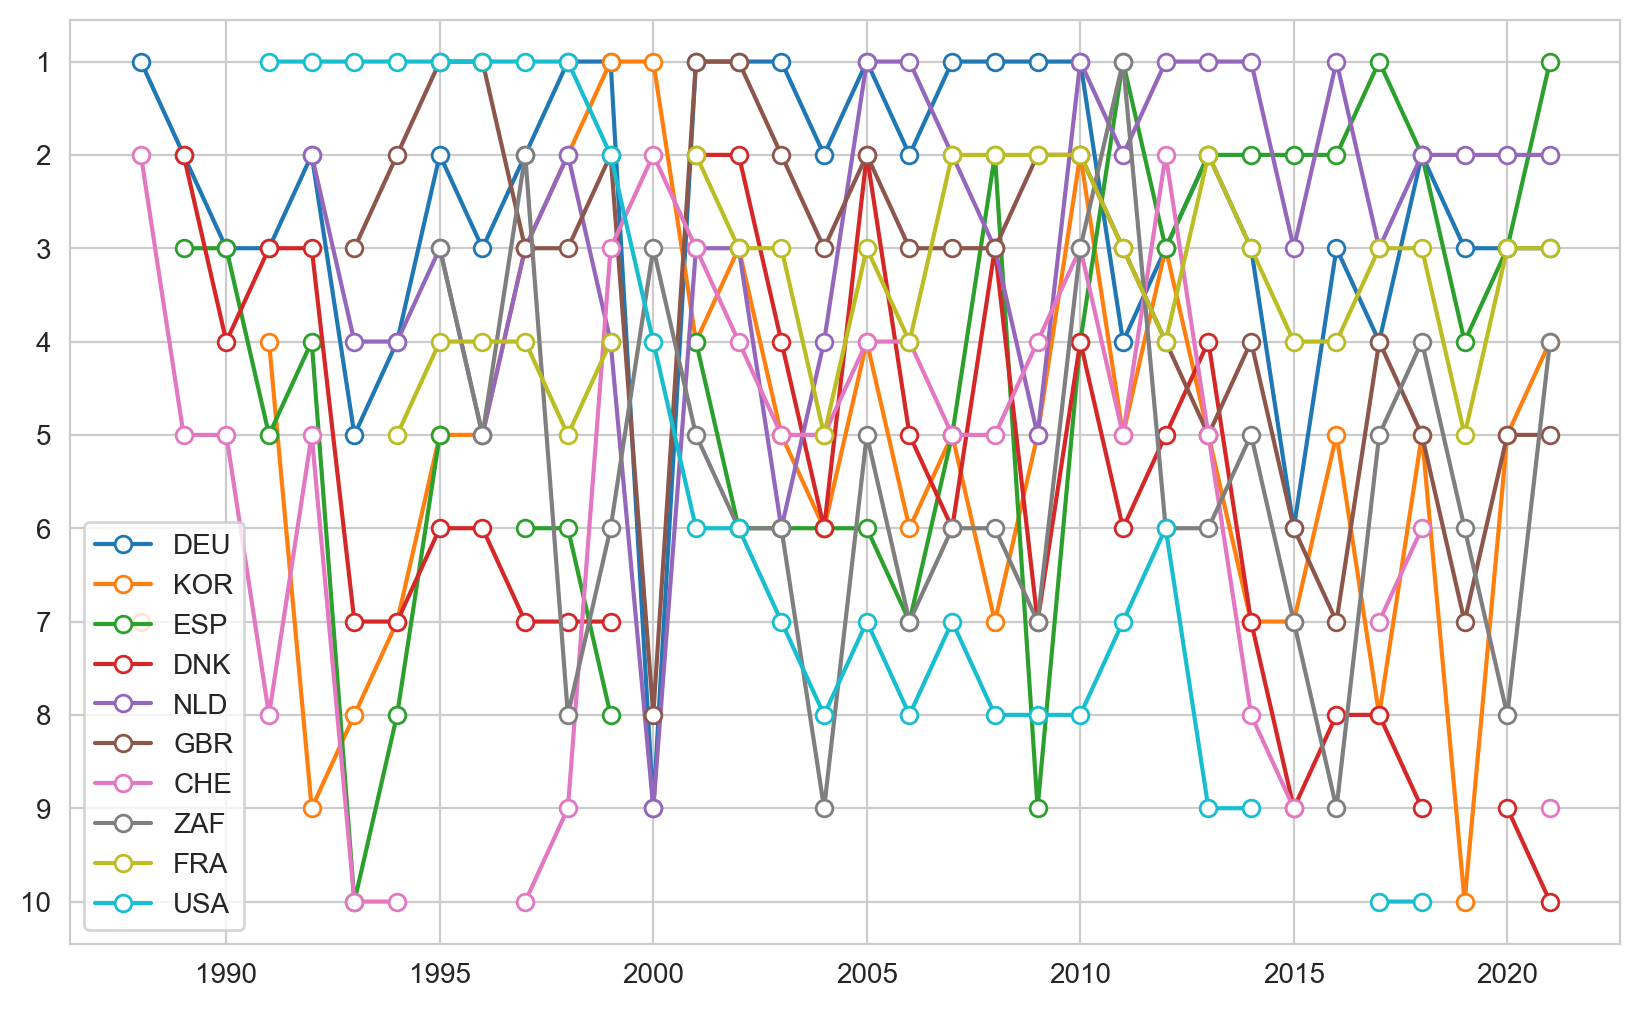

In [65]:
country = 'GBR'
total_alg = total_trade_df[total_trade_df['reporter'] == country]
total_alg
#c2 = countries_df[countries_df['partner'] == 'DZA']
#combined_country = pd.concat([c1,c2])
#combined_country.sort_values('year')
#
plt.plot(total_alg['year'],total_alg['total_exports']/1e6, linewidth=3)
plt.xlabel('Year')
plt.ylabel('Export USD$ Billions')
plt.title('Algeria Total Exports by Year')
plt.show()

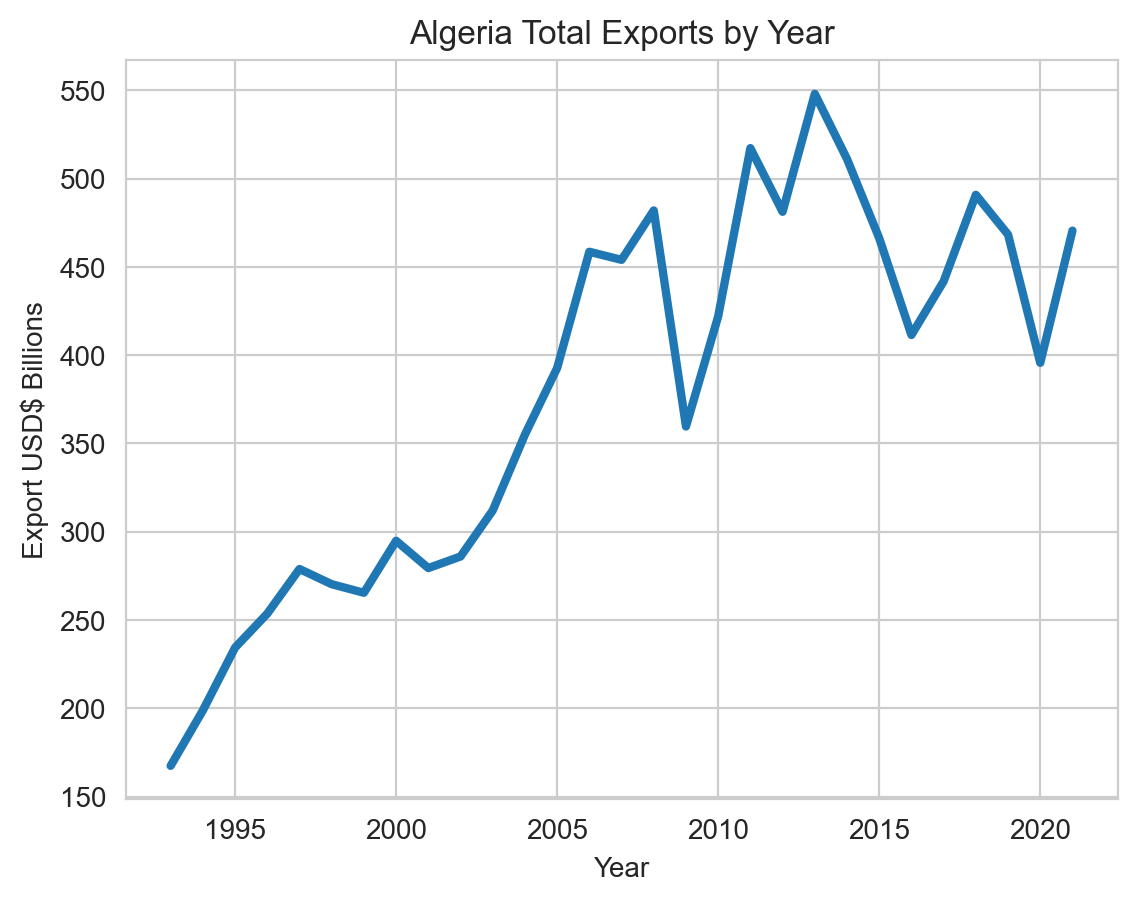

In [66]:
""" Choropleth Graph of the world exports """

# Adjusting the trade values to be in Billion USD
countries_adjusted = countries_df.copy()
countries_adjusted['export'] = countries_adjusted['export']/1e6
countries_adjusted['import'] = countries_adjusted['import']/1e6

# Getting data for all the plots
data = []
for year in reversed(sorted(countries_adjusted['year'].unique())):
    data.append(countries_adjusted[countries_adjusted['year'] == year].groupby('reporter').agg(total_exports=pd.NamedAgg(column='export', aggfunc='sum')).reset_index())
#data.append((total_trade_df.groupby('year')['total_exports'].sum() /1e9))

# Creating the main figure
rows = 7
cols = 5
fig = make_subplots(rows = rows, cols = cols, specs = [[{'type': 'choropleth'} for c in range(cols)] for r in range(rows)], horizontal_spacing = 0.01, vertical_spacing = 0.01, subplot_titles = [str(year) for year in reversed(sorted(countries_adjusted['year'].unique()))])

# Adding each subplot
for i in range(rows):
    for j in range(cols):
        if i*cols+j == 34:
            break
        fig.add_trace(px.choropleth(data[i*cols+j], locations='reporter', color='total_exports',
                                title=f"Year {i*cols+j+1990}", width=400).data[0], row = i+1, col = j+1)

for annotation in fig['layout']['annotations']:
    annotation['y'] -= 0.003

In [67]:
""" Plotting above graph """
fig.update_coloraxes(colorscale='Viridis', colorbar=dict(title='Exports Value (Billion USD)'))  # viridis is colorblind friendly
fig.update_layout(height=1600, width=2100)
fig.write_image("./data/choropleths.png")
fig.show()

In [68]:
""" Choropleth Graph of the world imports """

# Getting data for all the plots
data = []
for year in reversed(sorted(countries_adjusted['year'].unique())):
    data.append(countries_adjusted[countries_adjusted['year'] == year].groupby('reporter').agg(total_imports=pd.NamedAgg(column='import', aggfunc='sum')).reset_index())

# Creating the main figure
rows = 7
cols = 5
fig = make_subplots(rows = rows, cols = cols, specs = [[{'type': 'choropleth'} for c in range(cols)] for r in range(rows)], horizontal_spacing = 0.01, vertical_spacing = 0.01, subplot_titles = [str(year) for year in reversed(sorted(countries_adjusted['year'].unique()))])

# Adding each subplot
for i in range(rows):
    for j in range(cols):
        if i*cols+j == 34:
            break
        fig.add_trace(px.choropleth(data[i*cols+j], locations='reporter', color='total_imports', title=f"Year {i*cols+j+1990}",
                                    width=400).data[0], row = i+1, col = j+1)

for annotation in fig['layout']['annotations']:
    annotation['y'] -= 0.003

In [69]:
""" Plotting above graph """
fig.update_coloraxes(colorscale='cividis', colorbar=dict(title='Import Value (Billion USD)'))  # cividis is colorblind friendly
fig.update_layout(height=1600, width=2100)
fig.write_image("./data/imp_choropleths.png")
fig.show()

In [70]:
""" Time Series graph of countries entering the dataset """
index_range = range(1988,2022)
first_appearance_p = countries_df.groupby('partner')['year'].min().value_counts().sort_index().cumsum().reindex(index_range, fill_value=0)
first_appearance_r = countries_df.groupby('reporter')['year'].min().value_counts().sort_index().cumsum().reindex(index_range, fill_value=0)

for year, count in first_appearance_p.items():
    if count == 0:
        first_appearance_p.loc[year] = first_appearance_p.loc[year-1]

for year, count in first_appearance_r.items():
    if count == 0:
        first_appearance_r.loc[year] = first_appearance_r.loc[year-1]

first_appearance_p.plot(figsize=(10,3), color=cb.quantitative['brwblu'][0], linewidth=2, linestyle='--')
first_appearance_r.plot(figsize=(10,3), color=cb.quantitative['brwblu'][1], linewidth=2)
plt.legend(['Partner','Reporter'], fontsize='large')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.show()

first_appearance = countries_df.groupby('partner')['year'].min()
first_appearance.index = first_appearance.index.map(lambda x: iso_df[iso_df['iso3'] == x]['state_name'].values[0])
#len(first_appearance[first_appearance == 1988])

first_appearance = countries_df.groupby('reporter')['year'].min()
first_appearance.index = first_appearance.index.map(lambda x: iso_df[iso_df['iso3'] == x]['state_name'].values[0])
#len(first_appearance[first_appearance == 1988])

In [70]:
countries_df[countries_df['partner']=='ATA']

In [71]:
""" Average number of trade partners per reporter """
countries_df.groupby('reporter')['partner'].nunique().mean()

reporter partner  year       export    import
25355       AUS     ATA  2003    748.63400       NaN
25356       AUS     ATA  2004   3233.62600   0.52100
25357       AUS     ATA  2005  13422.67600  18.54800
25358       AUS     ATA  2006   4795.90100  16.83600
25359       AUS     ATA  2007   2790.16100  20.57500
...         ...     ...   ...          ...       ...
714216      VEN     ATA  2012          NaN   3.26100
714217      VEN     ATA  2013          NaN   4.73300
726404      ZWE     ATA  2002     49.42675       NaN
726405      ZWE     ATA  2005          NaN   0.07229
726406      ZWE     ATA  2014          NaN   6.57394

[717 rows x 5 columns]

In [72]:
""" Percentage of missing data """
miss_exp = countries_df['export'].isnull().sum() / countries_df['export'].count()*100
miss_imp = countries_df['import'].isnull().sum() / countries_df['import'].count()*100
print(f"Missing export values: {miss_exp}%\nMissing import values: {miss_imp}%")

175.95098039215685

In [73]:
""" Export data for network modelling """
countries_df.to_csv('./data/trade_model_data.csv', index=False)

Missing export values: 20.275616825710173%
Missing import values: 8.482070534799972%
